# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine **which demographic groups respond best to which offer type**. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

**You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer**. From a business perspective, **if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.**

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts **how much someone will spend based on demographics and offer type**. Or you could build a model that **predicts whether or not someone will respond to an offer**. Or, you don't need to build a machine learning model at all. You could **develop a set of heuristics that determine what offer you should send to each customer** (i.e., **75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A**).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

### The charts requires the new version of the seaborn (0.11.2), run the below to install a new version and then restart the Kernel.
##### condat update pandas indicated in above screenshot runs for a long time and remained unfinished. so pip install is an option mentioned in one of the knowledge article and is what adopted here

In [1]:
# import sys
# !{sys.executable} -m pip install seaborn==0.11.2

# #restart the kernel after installing the lastest version of seaborn

In [2]:
import seaborn as sns
sns.__version__

'0.11.2'

In [3]:
import pandas as pd
import numpy as np
import math
import datetime as datetime
import json
% matplotlib inline

import seaborn as sns
sns.set(style="darkgrid")
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [4]:
pd.__version__

'0.23.3'

In [5]:
pd.set_option('display.max_colwidth', 0)
pd.set_option('display.max_columns', 0)

In [6]:
from platform import python_version

print(python_version())

3.6.3


## Check the data in each of the three data files

In [7]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [8]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [9]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [10]:
print("portfolio shape {}, \nprofile shape {}, \ntranscript shape {}".format(portfolio.shape, profile.shape, transcript.shape))

portfolio shape (10, 6), 
profile shape (17000, 5), 
transcript shape (306534, 4)


## Transcript: Analyze and Create Features

In [11]:
x=transcript.event.unique()
print("event count = {0}\nunique events are {1}".format(len(x), x))

event count = 4
unique events are ['offer received' 'offer viewed' 'transaction' 'offer completed']


#### get unique keys from dictionary in values

In [12]:
keyslist =[]
for val in transcript['value']:
    for key in val.keys():
        keyslist.append(key)
        
set(keyslist)

{'amount', 'offer id', 'offer_id', 'reward'}

In [13]:
trans = transcript

def getOffer(dictval):
    if key in dictval:
        return dictval[key]
    else:
        return ""
#     return str(xx.keys())


for key in set(keyslist):
    trans[key] = transcript['value'].apply(getOffer)
    
    
# cc  = transcript['value'].apply(getOffer)
# print(cc.shape)
trans.head()

,event,person,time,value,reward,amount,offer id,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},,,9b98b8c7a33c4b65b9aebfe6a799e6d9,
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},,,0b1e1539f2cc45b7b9fa7c272da2e1d7,
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},,,2906b810c7d4411798c6938adc9daaa5,
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},,,fafdcd668e3743c1bb461111dcafc2a4,
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},,,4d5c57ea9a6940dd891ad53e9dbe8da0,


#### check if columns "offer_id and "offer id" both has any value in a same row i.e., mutually exclusive

In [14]:
x= trans[(trans['offer_id'] != "") & (trans['offer id'] != "")].shape[0]
print("total rows having both offer_id and offer id = ", x)

total rows having both offer_id and offer id =  0


In [15]:
## create a single offer column from offer id and offer_id
trans['offer'] = trans['offer id'] + trans['offer_id']
trans.head()

,event,person,time,value,reward,amount,offer id,offer_id,offer
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},,,9b98b8c7a33c4b65b9aebfe6a799e6d9,,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},,,0b1e1539f2cc45b7b9fa7c272da2e1d7,,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},,,2906b810c7d4411798c6938adc9daaa5,,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},,,fafdcd668e3743c1bb461111dcafc2a4,,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},,,4d5c57ea9a6940dd891ad53e9dbe8da0,,4d5c57ea9a6940dd891ad53e9dbe8da0


#### check amount and reward columns and make a single column out of the two

In [16]:
#check if any rows has both reard and amount
trans[(trans['amount'] == "") & (trans['reward'] == "")].shape[0]

134002

In [17]:
# check reward values
trans[trans['reward'] != ""]['reward'].unique()#u

array([2, 5, 10, 3], dtype=object)

In [18]:
# create a new column by combining reward and amount columns
trans['reward_amt'] = trans['reward'].apply(lambda x: 0 if x =="" else x) + trans['amount'].apply(lambda x: 0 if x =="" else x)

In [19]:
# replacing null with 0 in both reward and amount columns

trans['reward'] = trans['reward'].apply(lambda x: 0 if x =="" else x)
trans['amount'] = trans['amount'].apply(lambda x: 0 if x =="" else x)
trans.head()

,event,person,time,value,reward,amount,offer id,offer_id,offer,reward_amt
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,0.0,2906b810c7d4411798c6938adc9daaa5,,2906b810c7d4411798c6938adc9daaa5,0.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,0.0,fafdcd668e3743c1bb461111dcafc2a4,,fafdcd668e3743c1bb461111dcafc2a4,0.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0


#### create dummy columns into a new dataframe

In [20]:
trans['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [21]:
trans['event2'] = trans['event']

In [22]:
trans2 = pd.get_dummies(trans, columns=['event'])

In [23]:
trans2.head()

,person,time,value,reward,amount,offer id,offer_id,offer,reward_amt,event2,event_offer completed,event_offer received,event_offer viewed,event_transaction
0,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,offer received,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,offer received,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,0.0,2906b810c7d4411798c6938adc9daaa5,,2906b810c7d4411798c6938adc9daaa5,0.0,offer received,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,0.0,fafdcd668e3743c1bb461111dcafc2a4,,fafdcd668e3743c1bb461111dcafc2a4,0.0,offer received,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,offer received,0,1,0,0


In [24]:
trans2.drop(columns = ['value', 'offer_id','offer id'], inplace=True)

In [25]:
trans2.columns

Index(['person', 'time', 'reward', 'amount', 'offer', 'reward_amt', 'event2',
       'event_offer completed', 'event_offer received', 'event_offer viewed',
       'event_transaction'],
      dtype='object')

In [26]:
# trans2.head()

## Portfolio: Analylze and Create Features

In [27]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [28]:
# find the unique channels in the portfolio
# portfolio.offer_type.unique()

x = set([c for ch in portfolio.channels for c in ch])
print("event count = {0}\nunique events are {1}".format(len(x), x))

event count = 4
unique events are {'social', 'web', 'mobile', 'email'}


In [29]:
# find channels

channelsList =[]
for ch in portfolio.channels:
    channelsList.extend(ch)
    
uniqueChannels = set(channelsList)
print(uniqueChannels)

{'social', 'web', 'mobile', 'email'}


In [30]:
# create separate columns for each of the channels

def getChannel(val):
    if (channel in val):
        return 1
    else:
        return 0

for channel in uniqueChannels:
    portfolio[channel] = portfolio['channels'].apply(getChannel)

portfolio

,channels,difficulty,duration,id,offer_type,reward,social,web,mobile,email
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,0,1,1
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,0,1,1,1
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,0,1,1,1
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,0,1,0,1
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,0,1,1
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,0,1,1,1


In [31]:
portfolio.index

RangeIndex(start=0, stop=10, step=1)

In [32]:
portfolio2 = pd.get_dummies(portfolio, columns=['offer_type'])
portfolio2 = portfolio2.join(portfolio[['offer_type' ]].set_index(portfolio['id']), on=portfolio2['id'])

# portfolio2['offer_type2'] = portfolio['offer_type']
# portfolio2.head()

In [33]:
portfolio2.drop(columns=['channels'], inplace=True)

In [34]:
portfolio2.head()

,difficulty,duration,id,reward,social,web,mobile,email,offer_type_bogo,offer_type_discount,offer_type_informational,offer_type
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,1,0,1,1,1,0,0,bogo
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0,bogo
2,0,4,3f207df678b143eea3cee63160fa8bed,0,0,1,1,1,0,0,1,informational
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,0,1,1,1,1,0,0,bogo
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,0,1,0,1,0,1,0,discount


## Profile: Analyze and Create Features

In [35]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [36]:
profile2 = pd.get_dummies(profile, columns=['gender'])
profile2 = profile2.join(profile[['gender']].set_index(profile['id']), on='id')


# make incomde zero where the value is null of NaN
profile2['income']=profile2['income'].fillna(0)

#create income group in increment of 10,000
profile2['income_group'] = (profile2['income'] // 10000) * 10000

#create age group in increment of 5
profile2['age_group'] = (profile2['age'] // 5) * 5

profile2['membership_date'] = pd.to_datetime(profile2['became_member_on'], format='%Y%m%d', errors='ignore')

profile2['membership_year'] = profile2['became_member_on']//10000
profile2['membership_month'] =(profile2['became_member_on'] % 10000) // 100
profile2['membership_day'] = profile2['became_member_on'] % 100

profile2['membership_yy_mm'] = profile2['became_member_on']//100


profile2.head()

,age,became_member_on,id,income,gender_F,gender_M,gender_O,gender,income_group,age_group,membership_date,membership_year,membership_month,membership_day,membership_yy_mm
0,118,20170212,68be06ca386d4c31939f3a4f0e3dd783,0.0,0,0,0,None,0.0,115,2017-02-12,2017,2,12,201702
1,55,20170715,0610b486422d4921ae7d2bf64640c50b,112000.0,1,0,0,F,110000.0,55,2017-07-15,2017,7,15,201707
2,118,20180712,38fe809add3b4fcf9315a9694bb96ff5,0.0,0,0,0,None,0.0,115,2018-07-12,2018,7,12,201807
3,75,20170509,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1,0,0,F,100000.0,75,2017-05-09,2017,5,9,201705
4,118,20170804,a03223e636434f42ac4c3df47e8bac43,0.0,0,0,0,None,0.0,115,2017-08-04,2017,8,4,201708


## Join the three dataframe into a single dataframe

In [37]:
# profile2.head()

In [38]:
# portfolio2.head()

In [39]:
# trans2.head()

In [40]:
trans2[trans2['person'] == 'da7a7c0dcfcb41a8acc7864a53cf60fb']

,person,time,reward,amount,offer,reward_amt,event2,event_offer completed,event_offer received,event_offer viewed,event_transaction
263150,da7a7c0dcfcb41a8acc7864a53cf60fb,582,0,0.35,,0.35,transaction,0,0,0,1


In [41]:
#rename the id columns in the portfolio and profile dataframes

portfolio2.rename(columns={'id':'portfolio_id', 'reward': 'portfolio_reward'}, inplace=True)
profile2.rename(columns={'id':'profile_id'}, inplace=True)

In [42]:
starbucksdf = trans2.join(profile2.set_index('profile_id'), on='person' ).join(portfolio2.set_index('portfolio_id'), on='offer')

###### data be sorted by 'offer received', 'offer viewed', 'transaction', 'offer completed' for each customer, to avoid cases where received or completed or transactions or viewed are at the same time, but order differently. There are few instances, where transaction is prior to the recieved and this ordering will ensure right sequence is in plance


In [43]:
#sort the dataframe in following sequence 'offer_received, offer_viewed, transaction, offer_completed'
# this is needed in a scenario where offer viewed and completed are at same time

def sortSeq(val):
    if (val == 'offer received'):
        sortseq = 1
    elif (val == 'offer viewed'):
        sortseq = 2
    elif (val == 'transaction'):
        sortseq = 3
    elif (val == 'offer completed'):
        sortseq = 4
    else:
        sortseq = 0
    
    return sortseq

starbucksdf['sort_seq'] = starbucksdf['event2'].apply(sortSeq)

In [44]:
starbucksdf.sort_values(by=['person','time', 'sort_seq'], inplace=True)

In [45]:
starbucksdf.head()

,person,time,reward,amount,offer,reward_amt,event2,event_offer completed,event_offer received,event_offer viewed,event_transaction,age,became_member_on,income,gender_F,gender_M,gender_O,gender,income_group,age_group,membership_date,membership_year,membership_month,membership_day,membership_yy_mm,difficulty,duration,portfolio_reward,social,web,mobile,email,offer_type_bogo,offer_type_discount,offer_type_informational,offer_type,sort_seq
55972,0009655768c64bdeb2e877511632db8f,168,0,0.00,5a8bc65990b245e5a138643cd4eb9837,0.00,offer received,0,1,0,0,33,20170421,72000.0,0,1,0,M,70000.0,30,2017-04-21,2017,4,21,201704,0.0,3.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,informational,1
77705,0009655768c64bdeb2e877511632db8f,192,0,0.00,5a8bc65990b245e5a138643cd4eb9837,0.00,offer viewed,0,0,1,0,33,20170421,72000.0,0,1,0,M,70000.0,30,2017-04-21,2017,4,21,201704,0.0,3.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,informational,2
89291,0009655768c64bdeb2e877511632db8f,228,0,22.16,,22.16,transaction,0,0,0,1,33,20170421,72000.0,0,1,0,M,70000.0,30,2017-04-21,2017,4,21,201704,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
113605,0009655768c64bdeb2e877511632db8f,336,0,0.00,3f207df678b143eea3cee63160fa8bed,0.00,offer received,0,1,0,0,33,20170421,72000.0,0,1,0,M,70000.0,30,2017-04-21,2017,4,21,201704,0.0,4.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,informational,1
139992,0009655768c64bdeb2e877511632db8f,372,0,0.00,3f207df678b143eea3cee63160fa8bed,0.00,offer viewed,0,0,1,0,33,20170421,72000.0,0,1,0,M,70000.0,30,2017-04-21,2017,4,21,201704,0.0,4.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,informational,2


In [46]:
# starbucksdf[starbucksdf['person']=='da7a7c0dcfcb41a8acc7864a53cf60fb']

#### in order to analyze the offer and its effectiveness, we need to associate transactions with the offer. in the current dataset, transaction do not have an association with the offer.

#### Its given in problem statement, that offer regardless of being viewed, will influence the buying behavior (transactions) during the validity of the offer. To accomplish that, 
##### 1. for each offer received row, we create additional columns that reflects the validity of that offer. Using fillna, we fill in the null values for transactions, and offer-completed, offer-viewed. 
##### 2. we then compare the transaction time if it falls within the offer validity period. if so, we call it 'offer influence yes', otherwise 'offer influence no'. 
##### 3. we also have instances where person has not received any offer, we terms them as ' no offer



###### check if there are any person who have never received any offer and have transactions

In [47]:

ofr_rcvd = starbucksdf[starbucksdf['event_offer received'] == 1]
ofr_rcvd

all_persons= set(profile['id'].values)
person_with_offers = set(ofr_rcvd['person'].values)
person_wo_offer =list(all_persons.difference(person_with_offers))
print("Number of persons in profile table that have not received any offer {0}\n\n{1} ".format(len(person_wo_offer), person_wo_offer))



Number of persons in profile table that have not received any offer 6

['12ede229379747bd8d74ccdc20097ca3', 'c6e579c6821c41d1a7a6a9cf936e91bb', 'eb540099db834cf59001f83a4561aef3', '3a4874d8f0ef42b9a1b72294902afea9', 'da7a7c0dcfcb41a8acc7864a53cf60fb', 'ae8111e7e8cd4b60a8d35c42c1110555'] 


In [48]:
# number of transactions that are associated to these 6 persons

starbucksdf[starbucksdf.person.isin(person_wo_offer)]

,person,time,reward,amount,offer,reward_amt,event2,event_offer completed,event_offer received,event_offer viewed,event_transaction,age,became_member_on,income,gender_F,gender_M,gender_O,gender,income_group,age_group,membership_date,membership_year,membership_month,membership_day,membership_yy_mm,difficulty,duration,portfolio_reward,social,web,mobile,email,offer_type_bogo,offer_type_discount,offer_type_informational,offer_type,sort_seq
22092,12ede229379747bd8d74ccdc20097ca3,18,0,16.62,,16.62,transaction,0,0,0,1,91,20151005,70000.0,0,1,0,M,70000.0,90,2015-10-05,2015,10,5,201510,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
109815,12ede229379747bd8d74ccdc20097ca3,324,0,27.60,,27.60,transaction,0,0,0,1,91,20151005,70000.0,0,1,0,M,70000.0,90,2015-10-05,2015,10,5,201510,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
292962,12ede229379747bd8d74ccdc20097ca3,654,0,19.03,,19.03,transaction,0,0,0,1,91,20151005,70000.0,0,1,0,M,70000.0,90,2015-10-05,2015,10,5,201510,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
109340,3a4874d8f0ef42b9a1b72294902afea9,324,0,22.75,,22.75,transaction,0,0,0,1,55,20160816,88000.0,1,0,0,F,80000.0,55,2016-08-16,2016,8,16,201608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
142347,3a4874d8f0ef42b9a1b72294902afea9,378,0,27.20,,27.20,transaction,0,0,0,1,55,20160816,88000.0,1,0,0,F,80000.0,55,2016-08-16,2016,8,16,201608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
259644,3a4874d8f0ef42b9a1b72294902afea9,576,0,17.67,,17.67,transaction,0,0,0,1,55,20160816,88000.0,1,0,0,F,80000.0,55,2016-08-16,2016,8,16,201608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
106812,ae8111e7e8cd4b60a8d35c42c1110555,306,0,17.51,,17.51,transaction,0,0,0,1,54,20170106,72000.0,1,0,0,F,70000.0,50,2017-01-06,2017,1,6,201701,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
110707,ae8111e7e8cd4b60a8d35c42c1110555,330,0,28.70,,28.70,transaction,0,0,0,1,54,20170106,72000.0,1,0,0,F,70000.0,50,2017-01-06,2017,1,6,201701,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
184609,ae8111e7e8cd4b60a8d35c42c1110555,444,0,11.53,,11.53,transaction,0,0,0,1,54,20170106,72000.0,1,0,0,F,70000.0,50,2017-01-06,2017,1,6,201701,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
287598,ae8111e7e8cd4b60a8d35c42c1110555,636,0,9.72,,9.72,transaction,0,0,0,1,54,20170106,72000.0,1,0,0,F,70000.0,50,2017-01-06,2017,1,6,201701,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3


In [49]:
# NO LONGER NEEDED - CHANGE OF APPROACH

# # create a temporary column of values 'NoOffer'
# starbucksdf['tempcol'] = 'NoOffer'
# starbucksdf['person_wo_offer'] = starbucksdf[starbucksdf['person'].isin(person_wo_offer)]['tempcol']
# starbucksdf['person_wo_offer'] = starbucksdf['person_wo_offer'].fillna("")

In [50]:
# starbucksdf

##### 1. create a new column 'offer_duration' and fill the Null Values (which are against the transaction row),  with the value from previous row

In [51]:
# creat a new column 'offer_duration' and fill the Null Values (which are against the transaction row), 
# with the value from previous row
# this provide us with all rows having an offer validatity duration. The re-ordering of the dataframe, performed 
# earlier was necessary for this step

starbucksdf['offer_duration'] = starbucksdf['duration'].fillna(method='ffill')

In [52]:
#check if there are any null values
starbucksdf[starbucksdf['offer_duration'].isnull()]['person'].count()

0

In [53]:
# starbucksdf[starbucksdf['person']=='fe97aa22dd3e48c8b143116a8403dd52'][['duration','offer_duration']]

##### 2. create a column with Time for a row when 'offer received' . Subsequently the non-'offer received' (viewed, completed, transactions)  rows will be forward filled (ffill)

In [54]:
# starbucksdf[starbucksdf['person'] > 'da790000000000000000000000000000']

In [55]:
starbucksdf['time_offer_received'] = starbucksdf[starbucksdf['event_offer received'] == 1]['time']

In [56]:
# starbucksdf[starbucksdf['time_offer_received'].isnull()]

In [57]:
# starbucksdf['time_offer_received'] =starbucksdf[starbucksdf.person.isin(z)]['time_offer_received'].apply(lambda x: 0)

In [58]:
# starbucksdf[starbucksdf.person.isin(z)]

In [59]:
# starbucksdf[starbucksdf['person_wo_offer'] != ""][['person_wo_offer', 'event2']].count()

In [60]:
starbucksdf['time_offer_received'] = starbucksdf['time_offer_received'].fillna(method='ffill')

##### based on the time_offer_recieved column, create a column 'offer_validity'. This helps us know if the transactions is in influence of the offer offer-validity = time-offer-received + duration of the offer

In [61]:
starbucksdf['offer_validity_hrs'] =  starbucksdf['time_offer_received'] + (starbucksdf['offer_duration'] * 24)

In [62]:
# starbucksdf[starbucksdf['person']=='fe97aa22dd3e48c8b143116a8403dd52'][['event2', 'time', 'offer_duration','time_offer_received','offer_validity_hrs']]

In [63]:
# starbucksdf[starbucksdf['person']=='fe97aa22dd3e48c8b143116a8403dd52']

In [64]:
starbucksdf.columns

Index(['person', 'time', 'reward', 'amount', 'offer', 'reward_amt', 'event2',
       'event_offer completed', 'event_offer received', 'event_offer viewed',
       'event_transaction', 'age', 'became_member_on', 'income', 'gender_F',
       'gender_M', 'gender_O', 'gender', 'income_group', 'age_group',
       'membership_date', 'membership_year', 'membership_month',
       'membership_day', 'membership_yy_mm', 'difficulty', 'duration',
       'portfolio_reward', 'social', 'web', 'mobile', 'email',
       'offer_type_bogo', 'offer_type_discount', 'offer_type_informational',
       'offer_type', 'sort_seq', 'offer_duration', 'time_offer_received',
       'offer_validity_hrs'],
      dtype='object')

##### create a new column 'offer2', and copy the value of the offer that is influencing the transaction

In [65]:
# starbucksdf['offer2'] = starbucksdf[starbucksdf['event_offer received'] == 1]['offer']

In [66]:
# starbucksdf[['person','event2','offer','offer2']].head()
# starbucksdf[['person','event2','offer']].head()


In [67]:
# def setOffer2(val):
# #     print("val = ",val['offer2'], val['time'], val['offer_validity_hrs'], val['time_offer_received'])
#     if ((val['time'] >= val['time_offer_received']) &
#         (val['time'] <= val['offer_validity_hrs'])):
#         return val['offer2']
#     else:
#         return "NoOffer"       

# starbucksdf['offer2'] = starbucksdf.apply(setOffer2, axis=1)


##### assign offer to the transactions that are influenced by offer. Where there is no influence, use a value 'NoOffer' to indicate as such

In [68]:
# create a temporary column of values 'NoOffer'
starbucksdf['tempcol'] = 'NoOffer'
starbucksdf['temp_constant'] = 10


In [69]:
# starbucksdf['offer2'] =starbucksdf[(starbucksdf['person']== 'fe97aa22dd3e48c8b143116a8403dd52') & ~(starbucksdf['time'].between(starbucksdf['time_offer_received'], starbucksdf['offer_validity_hrs']))]['tempcol']

In [70]:
# create separate columns when the offer has influence and when it has no influence
# a factor of 10, will help in consolidating when certain row results has multiple values like both influence and no_influence
# a scenario where offer is viewed after its validity has expired

starbucksdf['offer_influence_yes'] =starbucksdf[
                                   (starbucksdf['time'].between(starbucksdf['time_offer_received'], 
                                                                 starbucksdf['offer_validity_hrs']))
                                  ]['temp_constant']

starbucksdf['offer_influence_no'] =starbucksdf[~
                                   (starbucksdf['time'].between(starbucksdf['time_offer_received'], 
                                                                 starbucksdf['offer_validity_hrs']))
                                  ]['temp_constant'] * 10


starbucksdf['offer_not_sent'] = starbucksdf[starbucksdf['person'].isin(person_wo_offer)]['temp_constant'] * 100

starbucksdf['offer2'] =starbucksdf[~
                                   (starbucksdf['time'].between(starbucksdf['time_offer_received'], 
                                                                 starbucksdf['offer_validity_hrs']))
                                  ]['tempcol']

starbucksdf['out-of-validity'] =starbucksdf[~(starbucksdf['time'].between(starbucksdf['time_offer_received'], starbucksdf['offer_validity_hrs']))]['tempcol']


In [71]:
starbucksdf['offer2'] =starbucksdf[(starbucksdf['time'].between(starbucksdf['time_offer_received'], starbucksdf['offer_validity_hrs']))]['offer']

In [72]:
#  https://stackoverflow.com/questions/43648160/using-fillna-method-on-multiple-columns-of-a-pandas-dataframe-failed

starbucksdf.fillna(dict.fromkeys(['offer_influence_yes','offer_influence_no','offer_not_sent'],0), inplace=True)
    
# starbucksdf[['offer_influence_yes','offer_influence_no','offer_not_sent']].fillna(value=0, inplace=True)

In [73]:
starbucksdf['influence_yes_no'] = starbucksdf['offer_influence_yes'] + starbucksdf['offer_influence_no']  + starbucksdf['offer_not_sent']

In [74]:
# https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#the-where-method-and-masking


conditions = [
    (starbucksdf['offer_not_sent'] == 1000),
    (starbucksdf['offer_influence_no'] == 100),
    (starbucksdf['offer_influence_yes'] == 10)
]

# choices = ['No Offer', 'No Influence', 'Offer Influence']
choices = ['No Offer', 'No Influence', starbucksdf['offer']]


starbucksdf['offer2'] = np.select(conditions, choices, default='exception')

In [75]:
# starbucksdf.head()

In [76]:
# starbucksdf[starbucksdf['person']=='da7a7c0dcfcb41a8acc7864a53cf60fb']

In [77]:
# starbucksdf[starbucksdf['person']=='fff0f0aac6c547b9b263080f09a5586a']

In [78]:
starbucksdf[starbucksdf['offer2'].isnull()] 

,person,time,reward,amount,offer,reward_amt,event2,event_offer completed,event_offer received,event_offer viewed,event_transaction,age,became_member_on,income,gender_F,gender_M,gender_O,gender,income_group,age_group,membership_date,membership_year,membership_month,membership_day,membership_yy_mm,difficulty,duration,portfolio_reward,social,web,mobile,email,offer_type_bogo,offer_type_discount,offer_type_informational,offer_type,sort_seq,offer_duration,time_offer_received,offer_validity_hrs,tempcol,temp_constant,offer_influence_yes,offer_influence_no,offer_not_sent,offer2,out-of-validity,influence_yes_no


In [79]:
# starbucksdf[~starbucksdf['influence_yes_no'].isin([10,100,1000])]

# starbucksdf[(starbucksdf['offer_influence_yes'] > 0) & (starbucksdf['offer_influence_no'] > 0)]

# tempperson = starbucksdf[starbucksdf['influence_yes_no'] > 1000]['person']
# starbucksdf[starbucksdf['person'].isin(tempperson)]

# starbucksdf['person'].isin([starbucksdf[starbucksdf['influence_yes_no'] > 1000]['person'].values])

In [80]:
# starbucksdf[starbucksdf['person'] =='12ede229379747bd8d74ccdc20097ca3']

# starbucksdf[starbucksdf['person'] =='0009655768c64bdeb2e877511632db8f']




In [81]:
# starbucksdf[starbucksdf['offer2'] =='']



In [82]:
# CHANGE OF APPROACH, NO LONGER NEEDED. USE OF NUMPY.SELECT SOLVES THE TEDIOUS WORKAROUND. YAY!!!


# starbucksdf['offer2'] = starbucksdf['offer2'].fillna(value="")
# starbucksdf['out-of-validity'] = starbucksdf['offer2'].fillna(value="")

In [83]:

# starbucksdf[['person','event2','offer','offer2','person_wo_offer']]
# starbucksdf[starbucksdf['offer2'] != ""][['person','event2','offer','offer2','person_wo_offer','out-of-validity']]


In [84]:
# CHANGE OF APPROACH, NO LONGER NEEDED. USE OF NUMPY.SELECT SOLVES THE TEDIOUS WORKAROUND. YAY!!!

# starbucksdf['offer2'] = starbucksdf['offer2'] + starbucksdf['person_wo_offer']

In [85]:
starbucksdf[starbucksdf['offer2']=='No Offer']['event2'].count()

20

In [86]:
# CHANGE OF APPROACH, NO LONGER NEEDED. USE OF NUMPY.SELECT SOLVES THE TEDIOUS WORKAROUND. YAY!!!

# starbucksdf['offer2'] = starbucksdf['offer2'] + starbucksdf['offer']

In [87]:
starbucksdf[(starbucksdf['offer2']=='No Offer') & (starbucksdf['offer'] != "")]

,person,time,reward,amount,offer,reward_amt,event2,event_offer completed,event_offer received,event_offer viewed,event_transaction,age,became_member_on,income,gender_F,gender_M,gender_O,gender,income_group,age_group,membership_date,membership_year,membership_month,membership_day,membership_yy_mm,difficulty,duration,portfolio_reward,social,web,mobile,email,offer_type_bogo,offer_type_discount,offer_type_informational,offer_type,sort_seq,offer_duration,time_offer_received,offer_validity_hrs,tempcol,temp_constant,offer_influence_yes,offer_influence_no,offer_not_sent,offer2,out-of-validity,influence_yes_no


In [88]:
# starbucksdf[starbucksdf['person'] == 'fe97aa22dd3e48c8b143116a8403dd52']

In [89]:
starbucksdf['offer2'] = starbucksdf['offer2'].replace("", np.nan)

In [90]:
starbucksdf['offer2'] = starbucksdf['offer2'].fillna(method='ffill')

In [91]:
# starbucksdf[starbucksdf['person'] == 'da7a7c0dcfcb41a8acc7864a53cf60fb']

In [92]:
# sb_person_wo_offer = starbucksdf[starbucksdf['person'].isin(person_wo_offer)].copy()

In [93]:
# type(sb_person_wo_offer)

In [94]:
# starbucksdf[starbucksdf['person'].isin(person_wo_offer)]

In [95]:
# sb_person_wo_offer[['offer2', 'offer_duration', 'time_offer_received','offer_validity_hrs']] = ""
# sb_person_wo_offer['offer2'] = ""

# sb_person_wo_offer.loc[:, ('offer2', 'offer_duration', 'time_offer_received','offer_validity_hrs')] = ""

# sb_person_wo_offer.loc[:, 'offer2'] =  np.nan



In [96]:
# sb_person_wo_offer

In [97]:
# starbucksdf.update(sb_person_wo_offer)

In [98]:
# starbucksdf[starbucksdf.person_wo_offer == 'No Offer'].count()

### Here we have a summary view by person, time-offer-received and offer
#### Now we have a dataframe with all transactions have the offer influencing them against them, we also the period of influence

In [99]:
starbucksdf[starbucksdf['person'] == 'de90515e9f174ddfb8b4c677448286ef'].groupby(['person','time_offer_received','offer2']).sum()
# starbucksdf[starbucksdf['person'] == 'fe97aa22dd3e48c8b143116a8403dd52'].groupby(['person','time_offer_received','offer2']).sum()

time        ...         influence_yes_no
person                           time_offer_received offer2                                        ...                         
de90515e9f174ddfb8b4c677448286ef 0.0                 ae264e3637204a6fb9bb56bc8210ddfd  810         ...         120.0           
                                 168.0               0b1e1539f2cc45b7b9fa7c272da2e1d7  1128        ...         40.0            
                                                     No Influence                      900         ...         200.0           
                                 504.0               fafdcd668e3743c1bb461111dcafc2a4  1620        ...         30.0            
                                 576.0               9b98b8c7a33c4b65b9aebfe6a799e6d9  3738        ...         60.0            

[5 rows x 38 columns]

In [100]:
sbsummarydf = starbucksdf.groupby(['person','time_offer_received','offer2']).sum().reset_index()

In [101]:
# sbsummarydf[sbsummarydf['person'] == 'fe97aa22dd3e48c8b143116a8403dd52']
sbsummarydf[sbsummarydf['person'] == 'de90515e9f174ddfb8b4c677448286ef']

,person,time_offer_received,offer2,time,reward,amount,reward_amt,event_offer completed,event_offer received,event_offer viewed,event_transaction,age,became_member_on,income,gender_F,gender_M,gender_O,income_group,age_group,membership_year,membership_month,membership_day,membership_yy_mm,difficulty,duration,portfolio_reward,social,web,mobile,email,offer_type_bogo,offer_type_discount,offer_type_informational,sort_seq,offer_duration,offer_validity_hrs,temp_constant,offer_influence_yes,offer_influence_no,offer_not_sent,influence_yes_no
81233,de90515e9f174ddfb8b4c677448286ef,0.0,ae264e3637204a6fb9bb56bc8210ddfd,810,10,172.88,182.88,1,1,1,9,660,242050932,888000.0,0,12,0,840000.0,660,24204,108,132,2420508,30.0,21.0,30.0,3.0,0.0,3.0,3.0,3.0,0.0,0.0,34,84.0,2016.0,120,120.0,0.0,0.0,120.0
81234,de90515e9f174ddfb8b4c677448286ef,168.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,1128,5,33.20,38.20,1,1,0,2,220,80683644,296000.0,0,4,0,280000.0,220,8068,36,44,806836,40.0,20.0,10.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,11,40.0,1632.0,40,40.0,0.0,0.0,40.0
81235,de90515e9f174ddfb8b4c677448286ef,168.0,No Influence,900,0,28.11,28.11,0,0,0,2,110,40341822,148000.0,0,2,0,140000.0,110,4034,18,22,403418,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,20.0,816.0,20,0.0,200.0,0.0,200.0
81236,de90515e9f174ddfb8b4c677448286ef,504.0,fafdcd668e3743c1bb461111dcafc2a4,1620,2,19.81,21.81,1,1,0,1,165,60512733,222000.0,0,3,0,210000.0,165,6051,27,33,605127,20.0,20.0,4.0,2.0,2.0,2.0,2.0,0.0,2.0,0.0,8,30.0,2232.0,30,30.0,0.0,0.0,30.0
81237,de90515e9f174ddfb8b4c677448286ef,576.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,3738,5,45.17,50.17,1,1,1,3,330,121025466,444000.0,0,6,0,420000.0,330,12102,54,66,1210254,15.0,21.0,15.0,0.0,3.0,3.0,3.0,3.0,0.0,0.0,16,42.0,4464.0,60,60.0,0.0,0.0,60.0


In [102]:
sbsummarydf.columns

Index(['person', 'time_offer_received', 'offer2', 'time', 'reward', 'amount',
       'reward_amt', 'event_offer completed', 'event_offer received',
       'event_offer viewed', 'event_transaction', 'age', 'became_member_on',
       'income', 'gender_F', 'gender_M', 'gender_O', 'income_group',
       'age_group', 'membership_year', 'membership_month', 'membership_day',
       'membership_yy_mm', 'difficulty', 'duration', 'portfolio_reward',
       'social', 'web', 'mobile', 'email', 'offer_type_bogo',
       'offer_type_discount', 'offer_type_informational', 'sort_seq',
       'offer_duration', 'offer_validity_hrs', 'temp_constant',
       'offer_influence_yes', 'offer_influence_no', 'offer_not_sent',
       'influence_yes_no'],
      dtype='object')

In [103]:
# following column have summed up values due to the group by and is no longer valid. we drop these and then retrieve them
# from the profiles and portfolio dataframes

sbsummarydf.drop(columns = ['time','age', 'became_member_on', 'income', 'age_group','income_group',
        'gender_F', 'gender_M', 'gender_O','difficulty', 'duration',
        'membership_year', 'membership_month', 'membership_day', 'membership_yy_mm',
        'portfolio_reward','offer_duration', 'offer_validity_hrs','social', 'web', 'mobile', 'email',
        'offer_type_bogo', 'offer_type_discount', 'offer_type_informational',
        'offer_duration', 'temp_constant', 'influence_yes_no', 'offer_influence_yes',
       'offer_influence_no', 'offer_not_sent', 'sort_seq'
                           ], inplace=True)

In [104]:
# sbsummarydf.drop(columns = ['social', 'web', 'mobile', 'email',
#        'offer_type_bogo', 'offer_type_discount', 'offer_type_informational'], inplace=True)

In [105]:
sbsummarydf.columns

Index(['person', 'time_offer_received', 'offer2', 'reward', 'amount',
       'reward_amt', 'event_offer completed', 'event_offer received',
       'event_offer viewed', 'event_transaction'],
      dtype='object')

##### count of the offers that are influenced by the offer, not influenced due to transaction being outside of validity period and ones which did not receive any offer


In [106]:
sbsummarydf.offer2.value_counts()

No Influence                        12146
0b1e1539f2cc45b7b9fa7c272da2e1d7    8849 
fafdcd668e3743c1bb461111dcafc2a4    8539 
2906b810c7d4411798c6938adc9daaa5    8274 
9b98b8c7a33c4b65b9aebfe6a799e6d9    8254 
2298d6c36e964ae4a3e7e9706d1fb8c2    8238 
ae264e3637204a6fb9bb56bc8210ddfd    8051 
f19421c1d4aa40978ebb69ca19b0e20d    7873 
4d5c57ea9a6940dd891ad53e9dbe8da0    7824 
5a8bc65990b245e5a138643cd4eb9837    7618 
3f207df678b143eea3cee63160fa8bed    7617 
No Offer                            6    
Name: offer2, dtype: int64

In [107]:
# sbsummarydf[sbsummarydf['person'] == 'de90515e9f174ddfb8b4c677448286ef']

### sbsummarydf -> it is a summary by person, time offer is received and offer-received. we create another dataframe 'sb2' where a new column is introduced 'offer3', based on the 'offer2' columns values. Here all the offer id are replaced by 'offer-influence' to consolidate and help with the grouping

In [108]:
sb2 = sbsummarydf.join(profile2.set_index('profile_id'), on='person')
# starbucksdf = trans2.join(profile2.set_index('id'), on='person' ).join(portfolio2.set_index('id'), on='offer')

In [109]:
sb2.columns

Index(['person', 'time_offer_received', 'offer2', 'reward', 'amount',
       'reward_amt', 'event_offer completed', 'event_offer received',
       'event_offer viewed', 'event_transaction', 'age', 'became_member_on',
       'income', 'gender_F', 'gender_M', 'gender_O', 'gender', 'income_group',
       'age_group', 'membership_date', 'membership_year', 'membership_month',
       'membership_day', 'membership_yy_mm'],
      dtype='object')

In [110]:
sb2 = sb2.join(portfolio2[['portfolio_id','social', 'web', 'mobile', 'email','offer_type',
       'offer_type_bogo', 'offer_type_discount', 'offer_type_informational']].set_index('portfolio_id'), on='offer2')

In [111]:
sb2['offer_type'].fillna('None', inplace=True)
# sb2.fillna(dict.fromkeys(['offer_type','offer_type_bogo','offer_type_discount','offer_type_informational'],'None'), inplace=True)
sb2.fillna(dict.fromkeys(['offer_type_bogo','offer_type_discount','offer_type_informational'],0), inplace=True)

In [112]:
# sb2[sb2['person'] == 'fe97aa22dd3e48c8b143116a8403dd52']

#### Summarize it further by combining into transactions against any offer and where there are no offers. Here the difference would be that offer-ids are masked by the value 'offer-influence'

In [113]:
# https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#the-where-method-and-masking


conditions = [
    (sb2['offer2'] == 'No Influence'),
    (sb2['offer2'] == 'No Offer')
]

# choices = ['No Offer', 'No Influence', 'Offer Influence']
choices = ['No Influence', 'No Offer']


sb2['offer3'] = np.select(conditions, choices, default='offer Influence')

In [114]:
sb2.offer3.value_counts()

offer Influence    81137
No Influence       12146
No Offer           6    
Name: offer3, dtype: int64

In [115]:
# CHANGE OF APPROACH, NO LONGER NEEDED. USE OF NUMPY.SELECT SOLVES THE TEDIOUS WORKAROUND. YAY!!!

# sb2['tempcol'] = 'Offer'
# sb2['tempcol2'] = 'NoOffer'
# sb2['tempcol3'] = 'NotViewed'

In [116]:
# CHANGE OF APPROACH, NO LONGER NEEDED. USE OF NUMPY.SELECT SOLVES THE TEDIOUS WORKAROUND. YAY!!!

# # sb2['offerYes'] =sb2[sb2['offer2'] != 'NoOffer']['tempcol']
# sb2['offerYes']       = sb2[(sb2['offer2'] != 'NoOffer') & ((sb2['event_offer viewed'] > 0) | (sb2['event_offer completed'] > 0))]['tempcol']
# sb2['offerNo']        = sb2[ sb2['offer2'] == 'NoOffer']['tempcol2']
# sb2['offerNotViewed'] = sb2[(sb2['event_offer received'] > 0) & (sb2['event_offer viewed'] == 0)]['tempcol3']

In [117]:
# CHANGE OF APPROACH, NO LONGER NEEDED. USE OF NUMPY.SELECT SOLVES THE TEDIOUS WORKAROUND. YAY!!!

# sb2['offerYes'] =sb2['offerYes'].fillna(value="")
# sb2['offerNo'] =sb2['offerNo'].fillna(value="")
# sb2['offerNotViewed'] = sb2['offerNotViewed'].fillna(value="")
# sb2['offer_type'] = sb2['offer_type'].fillna(value="")

In [118]:
# sb2['offerYesNo'] = sb2['offerYes'] + sb2['offerNo'] + sb2['offerNotViewed']

In [119]:
# sb2.drop(columns=['tempcol','tempcol2','tempcol3','offerYes','offerNo','offerNotViewed'], inplace=True)

In [120]:
# sb2[sb2['person'] == '0011e0d4e6b944f998e987f904e8c1e5']

In [121]:
# starbucksdf[starbucksdf['person'] == '0011e0d4e6b944f998e987f904e8c1e5']

In [122]:
# approach changed

# sb2[sb2['offerYesNo'] =='']



### SB3 dataframe. Here the grouping is similar to the SB2, the only different this time being that the offer-id is masked with the 'offer-influence' and is captured in a columns offer-3

In [123]:
sb3 = sb2.groupby(['person','offer3','offer_type']).sum().reset_index()

In [124]:
# sb2[(sb2.offer_type.isnull())  ]['offer3'].value_counts()

In [125]:
# sb2[sb2['person'] == '0011e0d4e6b944f998e987f904e8c1e5'].groupby(['person','offer3','offer_type']).sum().reset_index()


#### again, we drop the columns that are summed up due to the group by. we subsequently fetch these from profile and portfolio datafarmes

In [126]:
sb3.drop(columns=['age', 'became_member_on', 'age_group','income_group',
                  'membership_year','membership_month','membership_day', 'membership_yy_mm',
       'income', 'gender_F', 'gender_M', 'gender_O'], inplace=True)


In [127]:
# sb3.head()

In [128]:
sb3 = sb3.join(profile2.set_index('profile_id'), on='person')

# sb3 = sb3.join(profile[['id']].set_index('id'), on='person')

# sb3 = sb3.join(portfolio2[['id','social', 'web', 'mobile', 'email',
#        'offer_type_bogo', 'offer_type_discount', 'offer_type_informational']].set_index('id'), on='offer2')


In [129]:
sb3.head()

,person,offer3,offer_type,time_offer_received,reward,amount,reward_amt,event_offer completed,event_offer received,event_offer viewed,event_transaction,social,web,mobile,email,offer_type_bogo,offer_type_discount,offer_type_informational,age,became_member_on,income,gender_F,gender_M,gender_O,gender,income_group,age_group,membership_date,membership_year,membership_month,membership_day,membership_yy_mm
0,0009655768c64bdeb2e877511632db8f,offer Influence,bogo,408.0,5,8.57,13.57,1,1,1,1,1.0,1.0,1.0,1.0,1.0,0.0,0.0,33,20170421,72000.0,0,1,0,M,70000.0,30,2017-04-21,2017,4,21,201704
1,0009655768c64bdeb2e877511632db8f,offer Influence,discount,1080.0,4,96.87,100.87,2,2,1,6,1.0,2.0,2.0,2.0,0.0,2.0,0.0,33,20170421,72000.0,0,1,0,M,70000.0,30,2017-04-21,2017,4,21,201704
2,0009655768c64bdeb2e877511632db8f,offer Influence,informational,504.0,0,22.16,22.16,0,2,2,1,1.0,1.0,2.0,2.0,0.0,0.0,2.0,33,20170421,72000.0,0,1,0,M,70000.0,30,2017-04-21,2017,4,21,201704
3,00116118485d4dfda04fdbaba9a87b5c,No Influence,None,168.0,0,4.09,4.09,0,0,0,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,118,20180425,0.0,0,0,0,None,0.0,115,2018-04-25,2018,4,25,201804
4,00116118485d4dfda04fdbaba9a87b5c,offer Influence,bogo,744.0,0,0.00,0.00,0,2,2,0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,118,20180425,0.0,0,0,0,None,0.0,115,2018-04-25,2018,4,25,201804


In [130]:
# sb3[sb3.person =='de90515e9f174ddfb8b4c677448286ef']

### lets add a column to count the number of persons in grouping by adding a column with a value of 1. We then add this to the SB3 dataframe

In [131]:
sb3['pcount'] = 1

###### to enable counting the number of person 

In [132]:
sb_group_person= sb3.groupby(by=['person'])['amount', 'reward','event_transaction','pcount'].sum().reset_index()

In [133]:
sb_group_person.rename(columns={'amount': 'total_amt', 'reward' : 'total_reward', 'event_transaction' : 'total_transactions','pcount' : 'person_count'}, inplace=True)

In [134]:
sb_group_person.shape

(17000, 5)

In [135]:
sb_group_person.head()

,person,total_amt,total_reward,total_transactions,person_count
0,0009655768c64bdeb2e877511632db8f,127.60,9,8,3
1,00116118485d4dfda04fdbaba9a87b5c,4.09,0,3,2
2,0011e0d4e6b944f998e987f904e8c1e5,79.46,13,5,4
3,0020c2b971eb4e9188eac86d93036a77,196.86,14,8,4
4,0020ccbbb6d84e358d3414a3ff76cffd,154.05,13,12,4


In [136]:
sb3.columns

Index(['person', 'offer3', 'offer_type', 'time_offer_received', 'reward',
       'amount', 'reward_amt', 'event_offer completed', 'event_offer received',
       'event_offer viewed', 'event_transaction', 'social', 'web', 'mobile',
       'email', 'offer_type_bogo', 'offer_type_discount',
       'offer_type_informational', 'age', 'became_member_on', 'income',
       'gender_F', 'gender_M', 'gender_O', 'gender', 'income_group',
       'age_group', 'membership_date', 'membership_year', 'membership_month',
       'membership_day', 'membership_yy_mm', 'pcount'],
      dtype='object')

In [137]:
sb_group_person.columns

Index(['person', 'total_amt', 'total_reward', 'total_transactions',
       'person_count'],
      dtype='object')

In [138]:
sb3 = sb3.join(sb_group_person.set_index('person'), on='person')

In [139]:
# sb3[sb3['offerYesNo'] == ""]
sb3.head()

,person,offer3,offer_type,time_offer_received,reward,amount,reward_amt,event_offer completed,event_offer received,event_offer viewed,event_transaction,social,web,mobile,email,offer_type_bogo,offer_type_discount,offer_type_informational,age,became_member_on,income,gender_F,gender_M,gender_O,gender,income_group,age_group,membership_date,membership_year,membership_month,membership_day,membership_yy_mm,pcount,total_amt,total_reward,total_transactions,person_count
0,0009655768c64bdeb2e877511632db8f,offer Influence,bogo,408.0,5,8.57,13.57,1,1,1,1,1.0,1.0,1.0,1.0,1.0,0.0,0.0,33,20170421,72000.0,0,1,0,M,70000.0,30,2017-04-21,2017,4,21,201704,1,127.60,9,8,3
1,0009655768c64bdeb2e877511632db8f,offer Influence,discount,1080.0,4,96.87,100.87,2,2,1,6,1.0,2.0,2.0,2.0,0.0,2.0,0.0,33,20170421,72000.0,0,1,0,M,70000.0,30,2017-04-21,2017,4,21,201704,1,127.60,9,8,3
2,0009655768c64bdeb2e877511632db8f,offer Influence,informational,504.0,0,22.16,22.16,0,2,2,1,1.0,1.0,2.0,2.0,0.0,0.0,2.0,33,20170421,72000.0,0,1,0,M,70000.0,30,2017-04-21,2017,4,21,201704,1,127.60,9,8,3
3,00116118485d4dfda04fdbaba9a87b5c,No Influence,None,168.0,0,4.09,4.09,0,0,0,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,118,20180425,0.0,0,0,0,None,0.0,115,2018-04-25,2018,4,25,201804,1,4.09,0,3,2
4,00116118485d4dfda04fdbaba9a87b5c,offer Influence,bogo,744.0,0,0.00,0.00,0,2,2,0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,118,20180425,0.0,0,0,0,None,0.0,115,2018-04-25,2018,4,25,201804,1,4.09,0,3,2


### the data is prepared to answer the question, as to which demograhy should receive which offer:


In [140]:
# calculate the offer_complete_Percentage

sb3['offer_complete_percentage'] = (sb3['event_offer completed'] / sb3['event_offer received']) * 100
sb3['offer_complete_percentage'].fillna(0, inplace=True)

In [141]:
# plt.figure(figsize=(20,8))
# sns.barplot(x='gener', y='spent_percentage', hue='gender', data = over_half_purchase_wo_offer)

# plt.title('Relationship between Age, amount and percentage of amount spent')

#### a cross reference of number of times an offer was sent vs the completion

In [142]:
sbpivot_person = sb3[sb3['gender']=='F'].pivot_table(columns=['event_offer received'], index=['event_offer completed'], aggfunc=np.sum)['person_count' ]
sbpivot_person.fillna("")
# sb3[(sb3['gender']=='F') & (sb3['age'] == 18)]


event_offer received,0,1,2,3,4,5,6
event_offer completed,,,,,,,
0,12043,11984,5489,1577,284,29,1
1,,8544,3261,794,160,15,
2,,,7307,1462,222,16,
3,,,,3117,375,20,1
4,,,,,814,43,2
5,,,,,,101,2
6,,,,,,,4


In [143]:
# sb3['event_offer completed'].sum()/sb3['event_offer received'].sum()

In [144]:
# sb3['event_offer completed'].sum()

In [145]:
# sb3['event_offer received'].sum()

In [146]:
sb3['spent_percentage'] = (sb3['amount']/sb3['total_amt']) * 100

#### Plot showing by age, amount spent for each gender, under influence of offer, outside of offer influence and when no offer is received. What we had seen that no-offer applies to only 6 person, who all happen to be females and shows with green line below

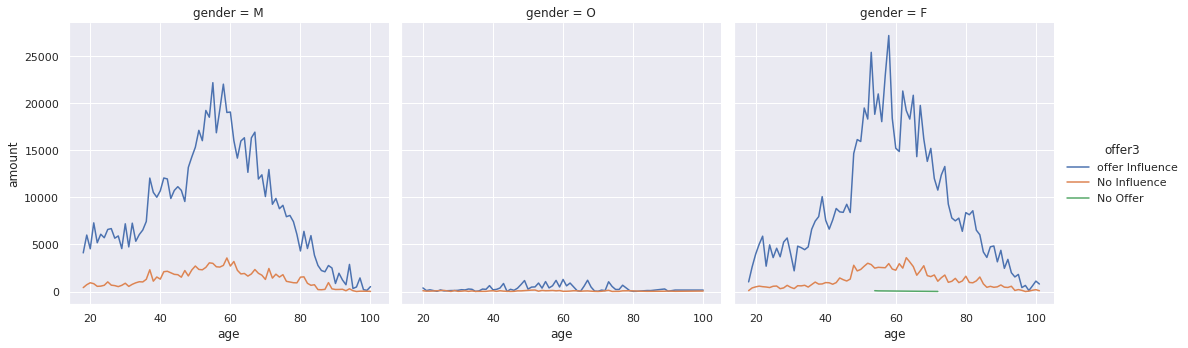

In [147]:
# plt.figure(figsize=(20,8))
# sns.scatterplot(x='age', y='spent_percentage', hue='offerYesNo', data = sb3)

sns.relplot(x='age', y='amount', hue='offer3', col='gender', estimator=sum, kind='line', ci=None, data = sb3)
# plt.title('Relationship between Age, amount and gender')

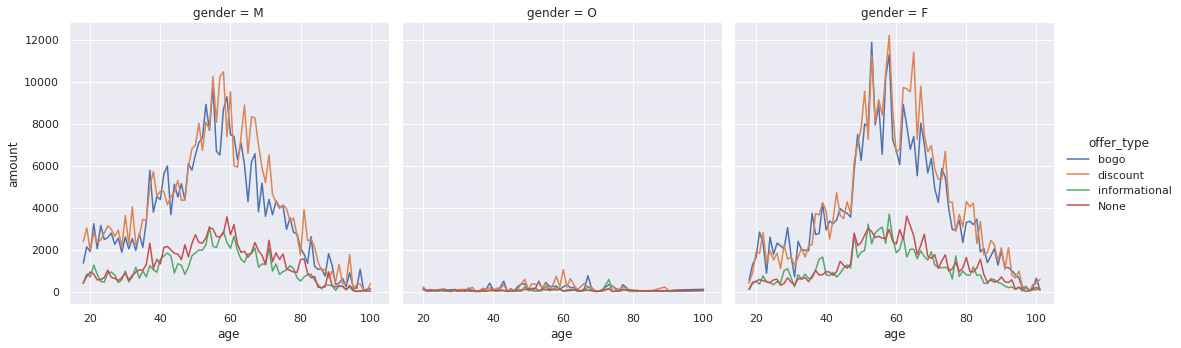

In [148]:
sns.relplot(x='age', y='amount', hue='offer_type', col='gender', kind='line', estimator=sum, ci=None, data = sb3)


In [149]:
# sb3['offer_complete_percentage'] = (sb3['event_offer completed'] / sb3['event_offer received']) * 100
# sb3['offer_complete_percentage'].fillna(0, inplace=True)

### Offer complete percentage category plot
##### informational offer cannot be completed and where offer is not recieved, can also not be completed
##### BOGO & DISCOUNT offers: Females completed more offer received in comaprison to males
##### Targetting females will yield better results

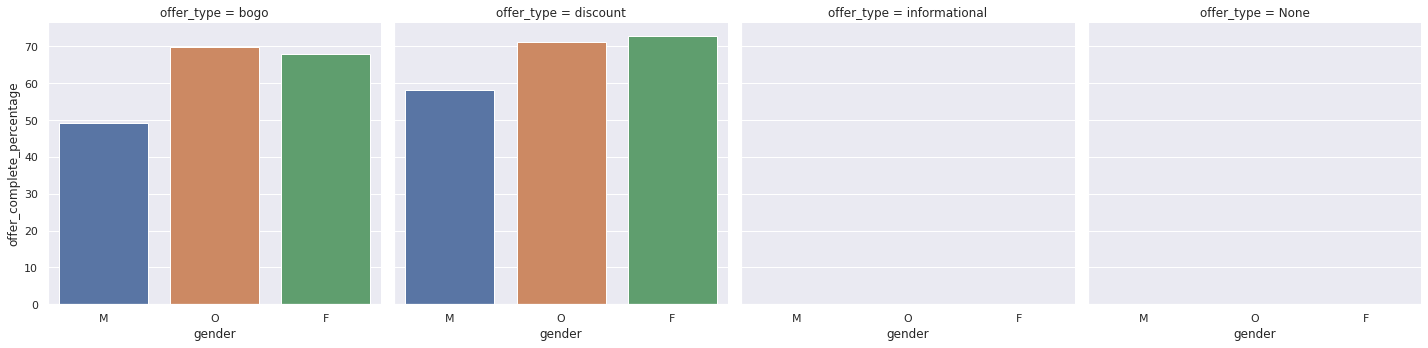

In [150]:
sns.catplot(x='gender', y='offer_complete_percentage' ,   col='offer_type', kind='bar', ci=None, data = sb3)


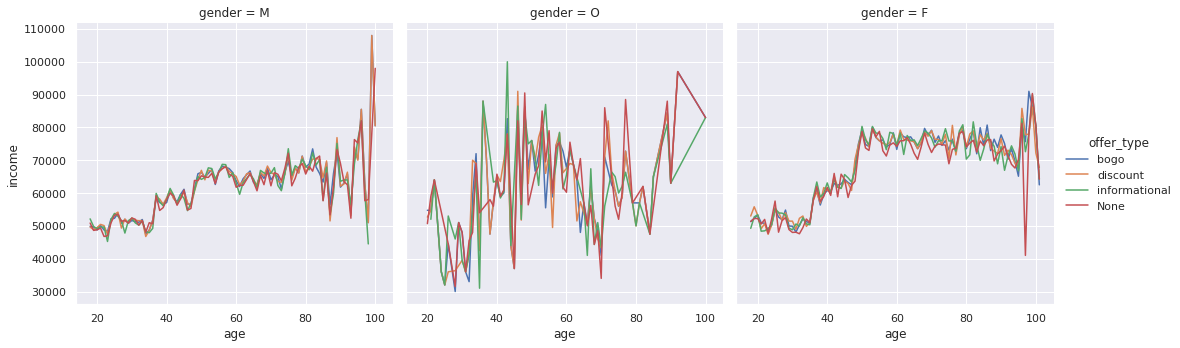

In [151]:
sns.relplot(x='age', y='income', hue='offer_type', col='gender', kind='line', ci=None, data = sb3)


In [152]:
# sb3.describe(include='all')

In [153]:
# g = sns.FacetGrid(sb3, col='gender', sharey=False,   hue='reward', height=7, aspect=1.1)
# g.map_dataframe(sns.histplot, x='age')
# g.set_axis_labels('Age', 'Count')
# g.add_legend()

In [154]:
sb3[['income','age','gender_M', 'gender_F', 'gender_O','amount','person_count']].corr()

,income,age,gender_M,gender_F,gender_O,amount,person_count
income,1.000000,-0.454324,0.138238,0.357662,0.023280,0.254222,-0.012297
age,-0.454324,1.000000,-0.384269,-0.141013,-0.031937,-0.089939,-0.014078
gender_M,0.138238,-0.384269,1.000000,-0.751869,-0.111472,-0.025154,0.006241
gender_F,0.357662,-0.141013,-0.751869,1.000000,-0.083852,0.136550,0.007807
gender_O,0.023280,-0.031937,-0.111472,-0.083852,1.000000,0.012205,-0.010264
amount,0.254222,-0.089939,-0.025154,0.136550,0.012205,1.000000,-0.119411
person_count,-0.012297,-0.014078,0.006241,0.007807,-0.010264,-0.119411,1.000000


In [155]:
# sb3.head()

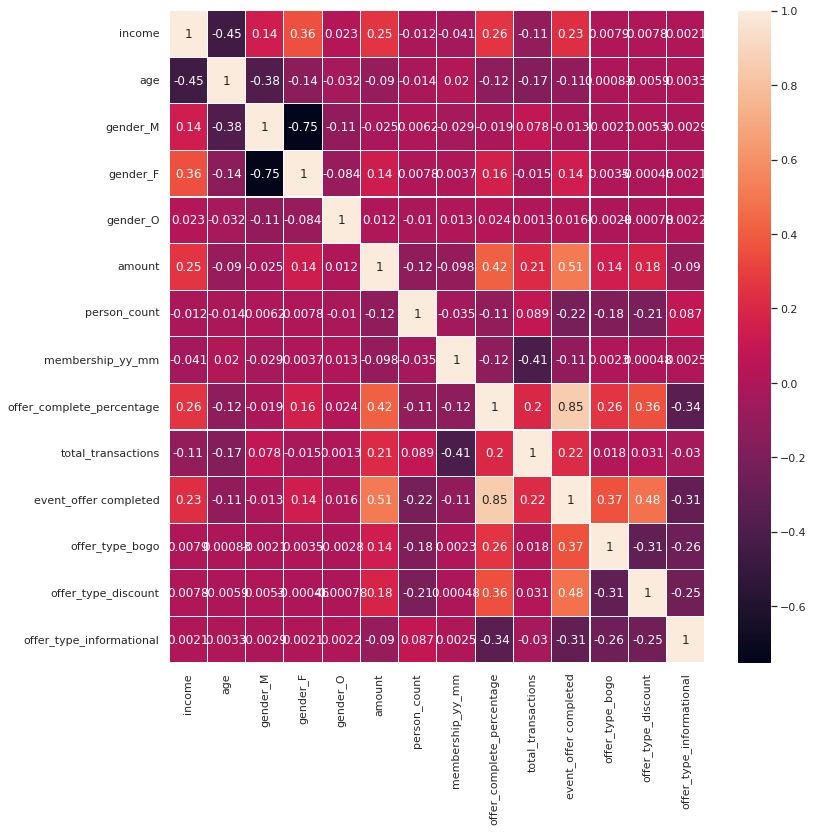

In [156]:
correlation = sb3[['income','age','gender_M', 'gender_F', 
                   'gender_O','amount','person_count',
                   'membership_yy_mm','offer_complete_percentage',
                   'total_transactions','event_offer completed',
                   'offer_type_bogo','offer_type_discount','offer_type_informational'
                  ]].corr()
plt.figure(figsize=(12,12))
sns.heatmap(correlation, linecolor='white',linewidths=0.1, annot=True)
# plt.title('Correlation Matrix')
# plt.xlabel('starbucks offers')
# plt.ylabel('starbucks offers')
plt.show()

In [157]:
# sb3.head()

In [158]:
def plotGraph(df, gender, gender_full):
    plt.figure(figsize=(40,12))
    ax = plt.subplot()

    plt.style.use('default')
    plt.grid(True, which='both')

#     gender='M'
    age_step = 5
    age_min = (df[df['gender'] == gender].age.min() // age_step ) * age_step
    age_max = ((df[df['gender'] == gender].age.max() + age_step ) // age_step) * age_step

    sns.lineplot(x='age', y='amount', 
                 hue='offer_type' , style='offer3',  
                 legend='full',
                 estimator='sum',
                 ci=None, marker="o", 
                 data = df[df['gender'] == gender]
                )
    ax.set_xticks(np.arange(age_min, age_max, 5))
    ax.set_xlabel('Age')
    ax.set_ylabel('Amount Spent')

    plt.title('For ' + gender_full + ' : Relationship between Age, Amount Spent and offer')


In [159]:

def groupdf (df, gender, gender_full):

    # group the dataframe for a gender by age and offer type and then sum the amount and the number of person
    # 
    # There are two trends in the data, where BOGO and DISCOUNT offers are competing
    # and where NO OFFER and INFORMATIONAL offers are competing as well
    #
    # We first take the average spent by dividing amount spent by the number of persons
    # 
    # Then evaluate which offer is better BOGO or DISCOUNT
    #
    # Among the people who didn't receive the offer and the ones that receives the informational offer, 
    # the second comparison evaluate if sending INFORMATIONAL offer is worth or not sending is better
    #

    group_offer  = df[df['gender']== gender].groupby(['age','offer_type'])['amount'].sum().unstack();
    group_person = df[df['gender']== gender].groupby(['age','offer_type'])['person_count'].sum().unstack();

    avg_spent_age = group_offer /  group_person

    
    conditions = [
        (avg_spent_age['bogo'] >  avg_spent_age['discount']) ,
        (avg_spent_age['bogo'] <  avg_spent_age['discount']) ]

    choices = ['send bogo offer', 'send discount offer']

    avg_spent_age['bogo_or_discount'] = np.select(conditions, choices, default='send either bogo or discount')


    conditions = [
        (avg_spent_age['None'] >  avg_spent_age['informational']),
        (avg_spent_age['None'] <  avg_spent_age['informational'])
    ]

    choices = ['dont send informational offer', 'send informational email']

    avg_spent_age['info_or_none'] = np.select(conditions, choices, default='dont send informational offer')

    
    bogo = avg_spent_age[avg_spent_age['bogo_or_discount'] == 'send bogo offer'].index.values
    discount = avg_spent_age[avg_spent_age['bogo_or_discount'] == 'send discount offer'].index.values
    bogo_discount = avg_spent_age[avg_spent_age['bogo_or_discount'] == 'send either bogo or discount'].index.values

    dont_send_info = avg_spent_age[avg_spent_age['info_or_none'] == 'dont send informational offer'].index.values
    send_info = avg_spent_age[avg_spent_age['info_or_none'] == 'send informational email'].index.values

    
    print('{0} - send bogo offer to the {1} out of {2} age group \n {3} \n '.format(gender_full, len(bogo), len(avg_spent_age), bogo) )
    print('{0} - send discount offer to the {1} out of {2} age group \n {3} \n '.format(gender_full, len(discount), len(avg_spent_age), discount) )
    print('{0} - send any, bogo or discount offer to the {1} out of {2} age group \n {3} \n '.format(gender_full, len(bogo_discount), len(avg_spent_age), bogo_discount) )

    print('{0} - don''t send informational offer to the {1} out of {2} age group \n {3} \n '.format(gender_full, len(dont_send_info), len(avg_spent_age), dont_send_info) )
    print('{0} - send informational offer  to the {1} out of {2} age group \n {3} \n '.format(gender_full, len(send_info), len(avg_spent_age), send_info) )

   
    return True


------------------------------------------
Evaluating the Female Demography
------------------------------------------

Female - send bogo offer to the 27 out of 84 age group 
 [ 18  19  21  24  25  26  27  29  32  33  34  36  39  41  44  45  49  52
  53  55  83  85  91  93  94  98 100] 
 
Female - send discount offer to the 57 out of 84 age group 
 [ 20  22  23  28  30  31  35  37  38  40  42  43  46  47  48  50  51  54
  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  84  86  87  88  89  90  92  95  96
  97  99 101] 
 
Female - send any, bogo or discount offer to the 0 out of 84 age group 
 [] 
 
Female - dont send informational offer to the 55 out of 84 age group 
 [ 21  24  25  26  31  33  36  40  41  43  44  45  47  48  49  50  51  52
  53  54  57  60  61  63  64  65  66  67  68  69  71  72  73  74  76  78
  79  80  81  83  84  85  86  87  88  89  90  91  92  93  94  96  98  99
 100] 
 
Female - send informational offer 

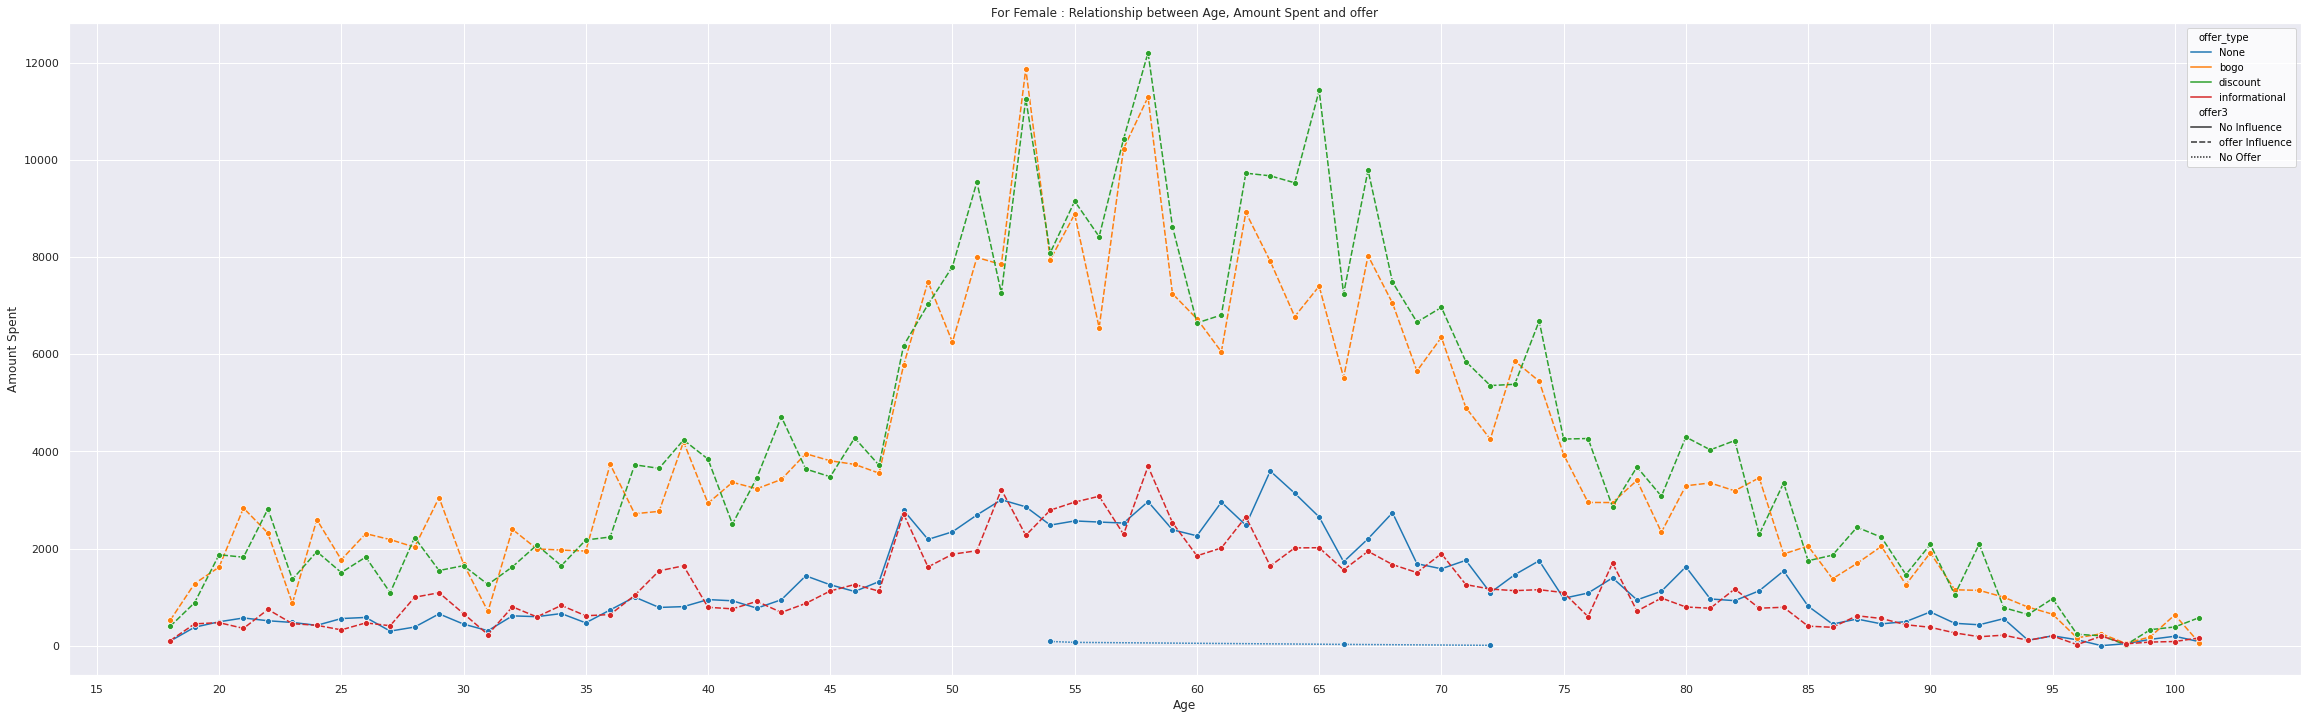

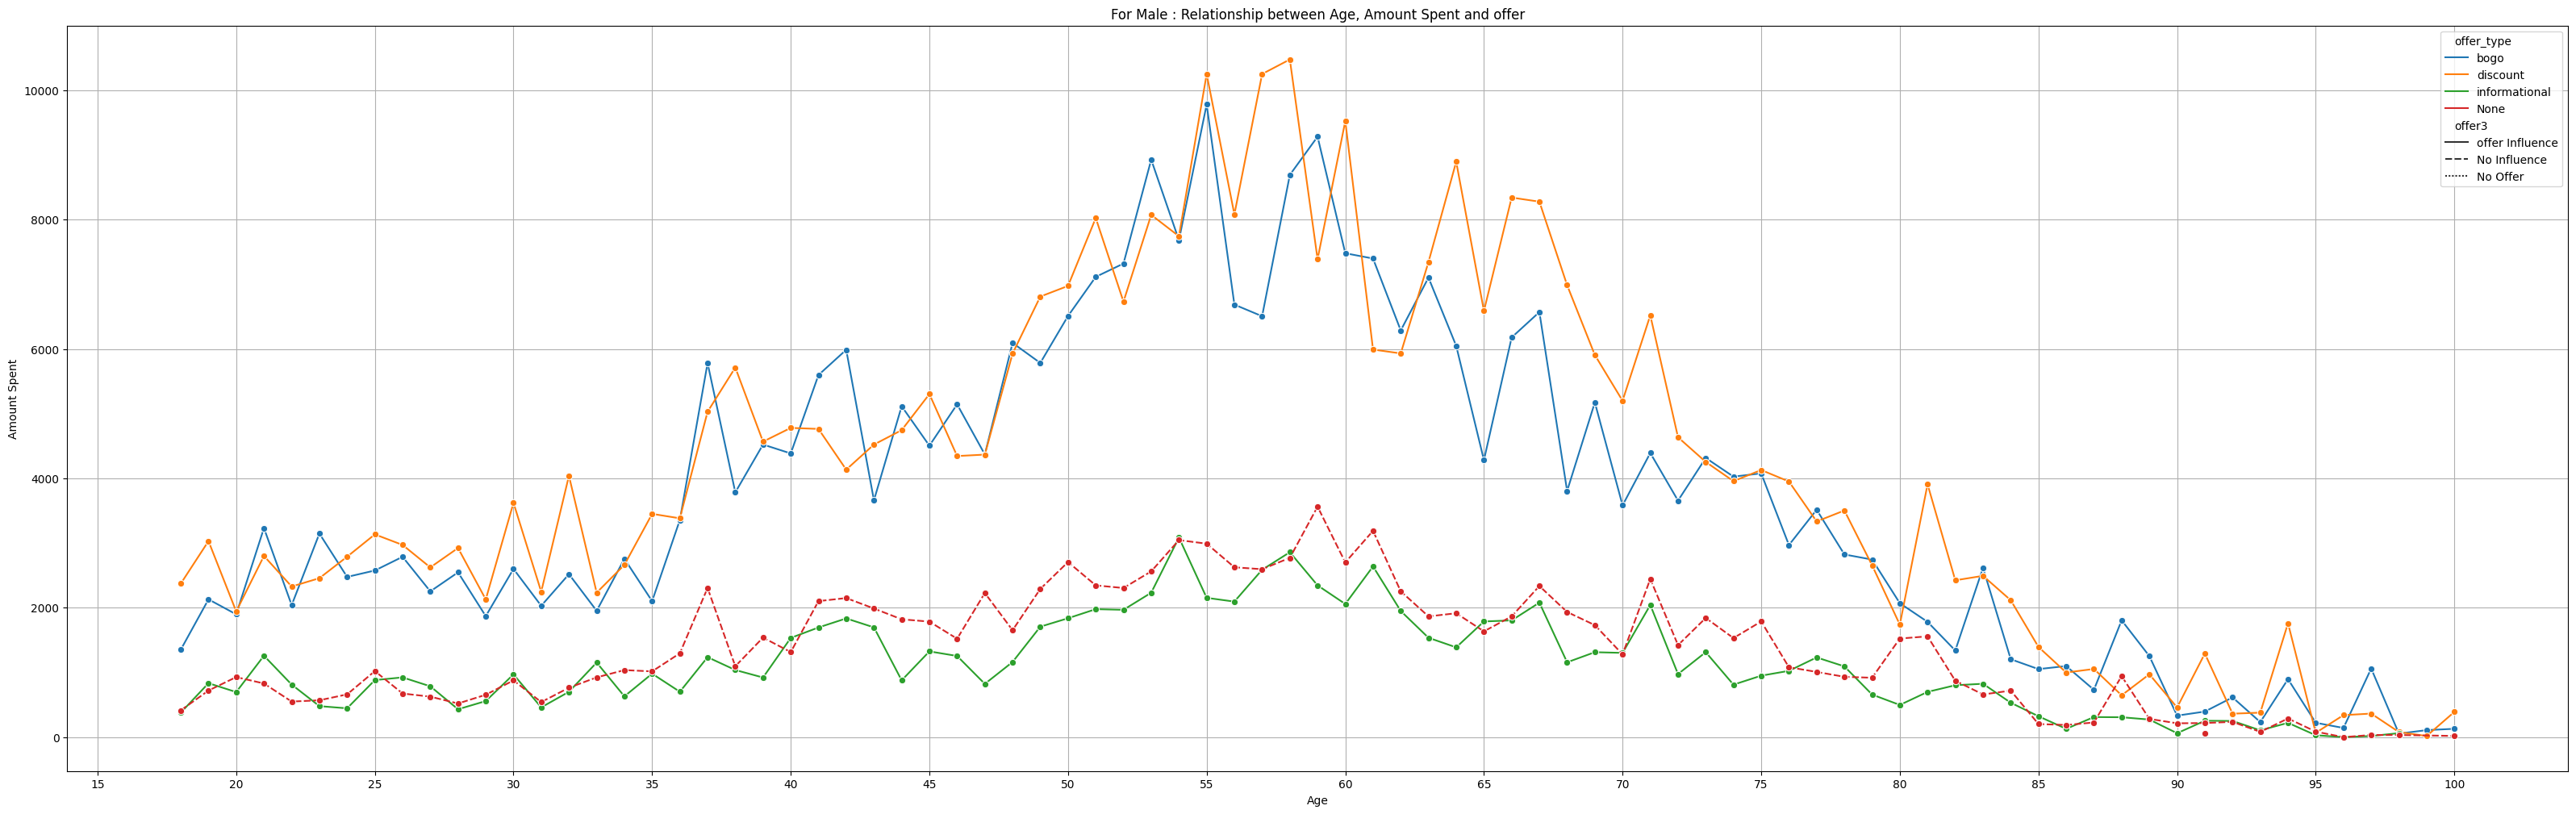

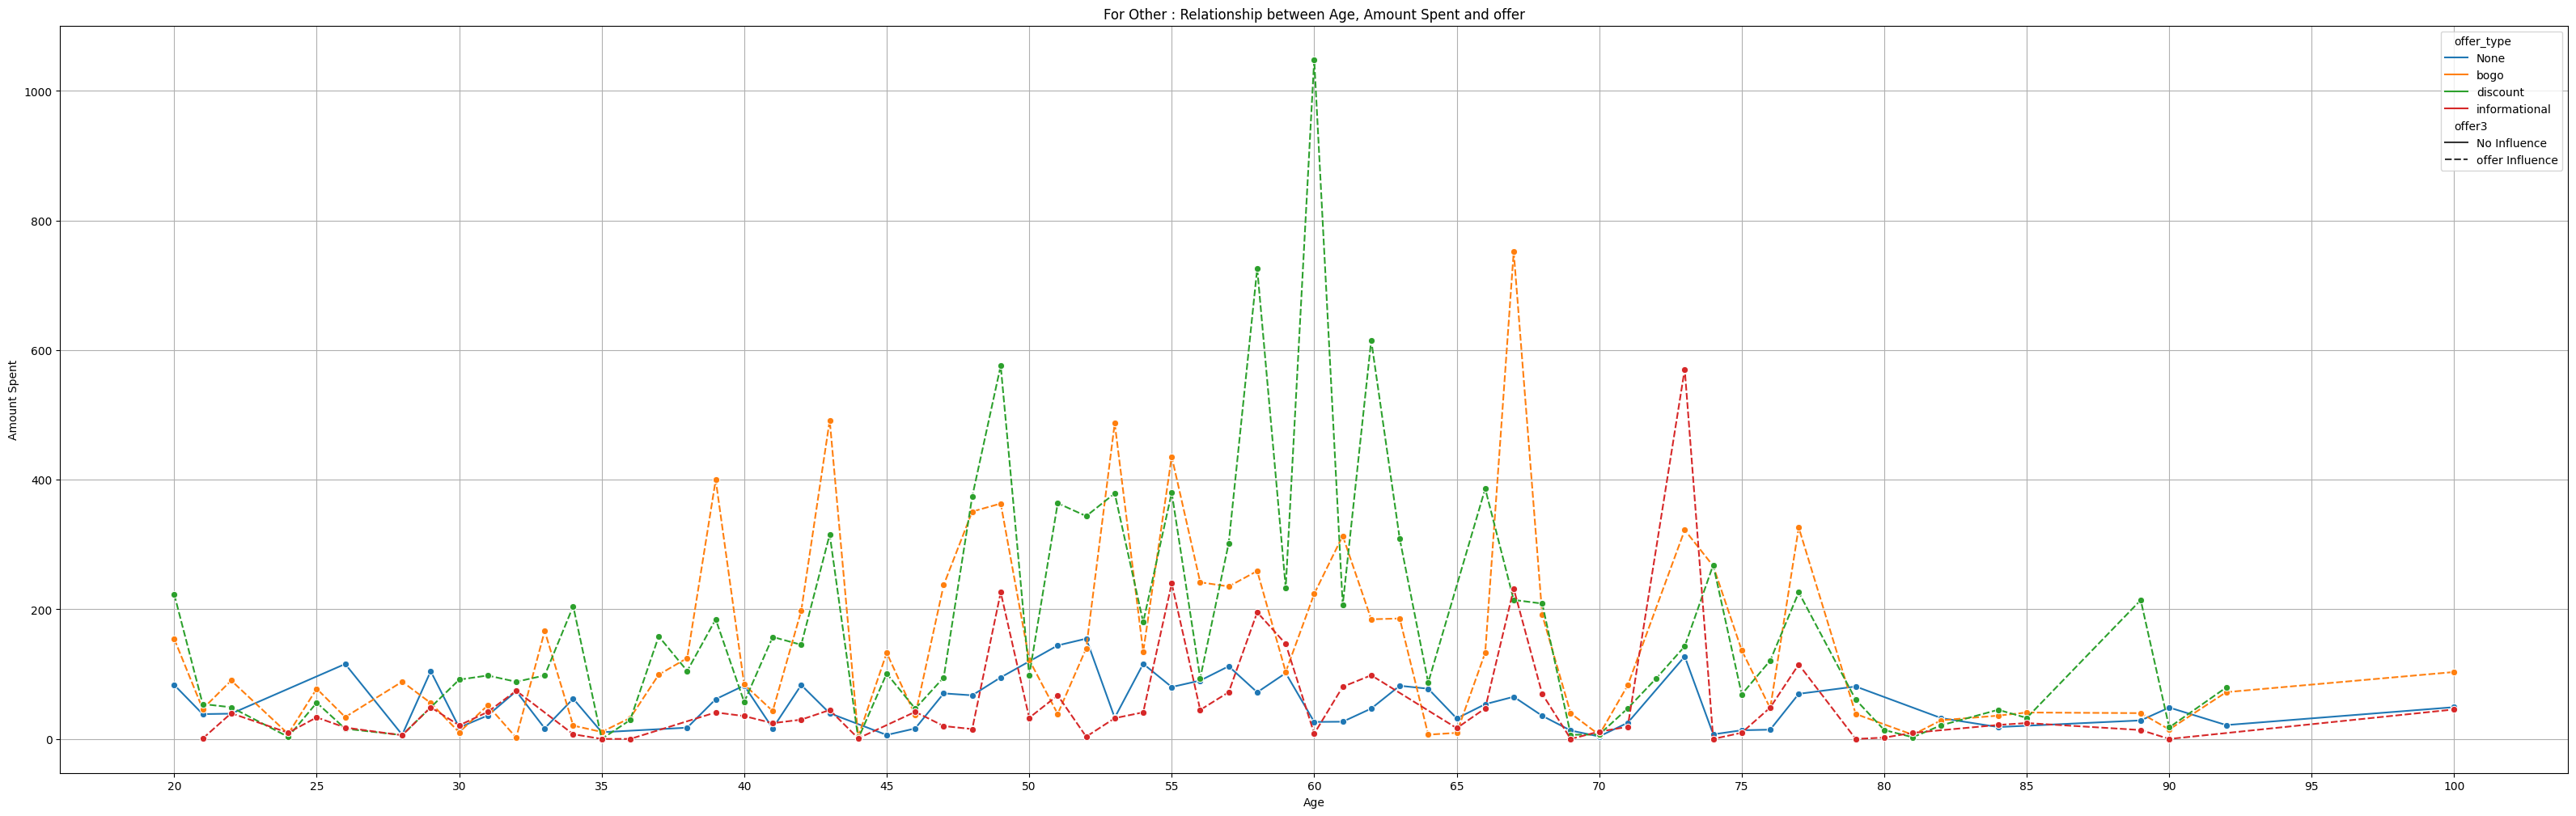

In [160]:
for g in ['F','M','O']:
    if (g == 'F'):
        gender_full = 'Female'
    elif (g == 'M'):
        gender_full = 'Male'
    elif (g == 'O'):
        gender_full = 'Other'

    print("------------------------------------------")
    print("Evaluating the {0} Demography".format(gender_full))
    print("------------------------------------------\n")
    plotGraph(sb3, g, gender_full)
    groupdf(sb3, g, gender_full)



### Lets look at the offer completion below. However, using the amount spent as a factor results in greater profitability. Completion offer means reaching the difficulty set for the offer, whereas, customer spending higher might yield better result
##### Also note, Informational offer has no completion, while they are received, hence the percentage completion comes to zero. For No-Offer, offer is NOT received, and there is no completion, hence it comes to NaN

In [161]:
def getCompletedDf(df, gender):
    dfcompleted=df[df['gender']== gender].groupby(['age','offer_type'])['event_offer completed'].sum().unstack();
    dfreceived=df[df['gender']== gender].groupby(['age','offer_type'])['event_offer received'].sum().unstack();

    df_calculated=dfcompleted/dfreceived*100
    df_calculated=df_calculated.reset_index()
    
    return df_calculated

In [162]:
def plotCompletionChart(df, gender, gender_full):
    
    plt.figure(figsize=(40,12))
    ax = plt.subplot()

    plt.style.use('default')
    plt.grid(True, which='both')

#     gender='F'
    age_step = 5
    age_min = (df['age'].min() // age_step ) * age_step
    age_max = ((df['age'].max() + age_step ) // age_step) * age_step

    # hue='discount' , style='discount',  

    sns.lineplot(x='age', y='bogo', 
                 legend='full',
                 estimator='sum',
                 ci=None, marker="o", data = df
                )
    sns.lineplot(x='age', y='discount',
                 legend='full',
                 estimator='sum',
                 ci=None, marker="o", data = df
                )

    ax.set_xticks(np.arange(age_min, age_max, 5))
    ax.set_xlabel('Age')
    ax.set_ylabel('Offer Completion Percentage')

    plt.title('For ' + gender_full + ' : percentage of offer completion for BOGO and Discount Offer')

------------------------------------------
Evaluating the Female Demography
------------------------------------------

offer_type  age  None       bogo   discount  informational
0           18  NaN    46.875000  65.217391  0.0          
1           19  NaN    58.181818  45.833333  0.0          
2           20  NaN    59.701493  67.307692  0.0          
3           21  NaN    62.820513  75.675676  0.0          
4           22  NaN    54.666667  59.302326  0.0          
------------------------------------------
Evaluating the Male Demography
------------------------------------------

offer_type  age  None       bogo   discount  informational
0           18  NaN    41.000000  59.793814  0.0          
1           19  NaN    27.319588  48.554913  0.0          
2           20  NaN    32.240437  46.583851  0.0          
3           21  NaN    37.908497  43.529412  0.0          
4           22  NaN    34.722222  39.880952  0.0          
------------------------------------------
Evaluating 

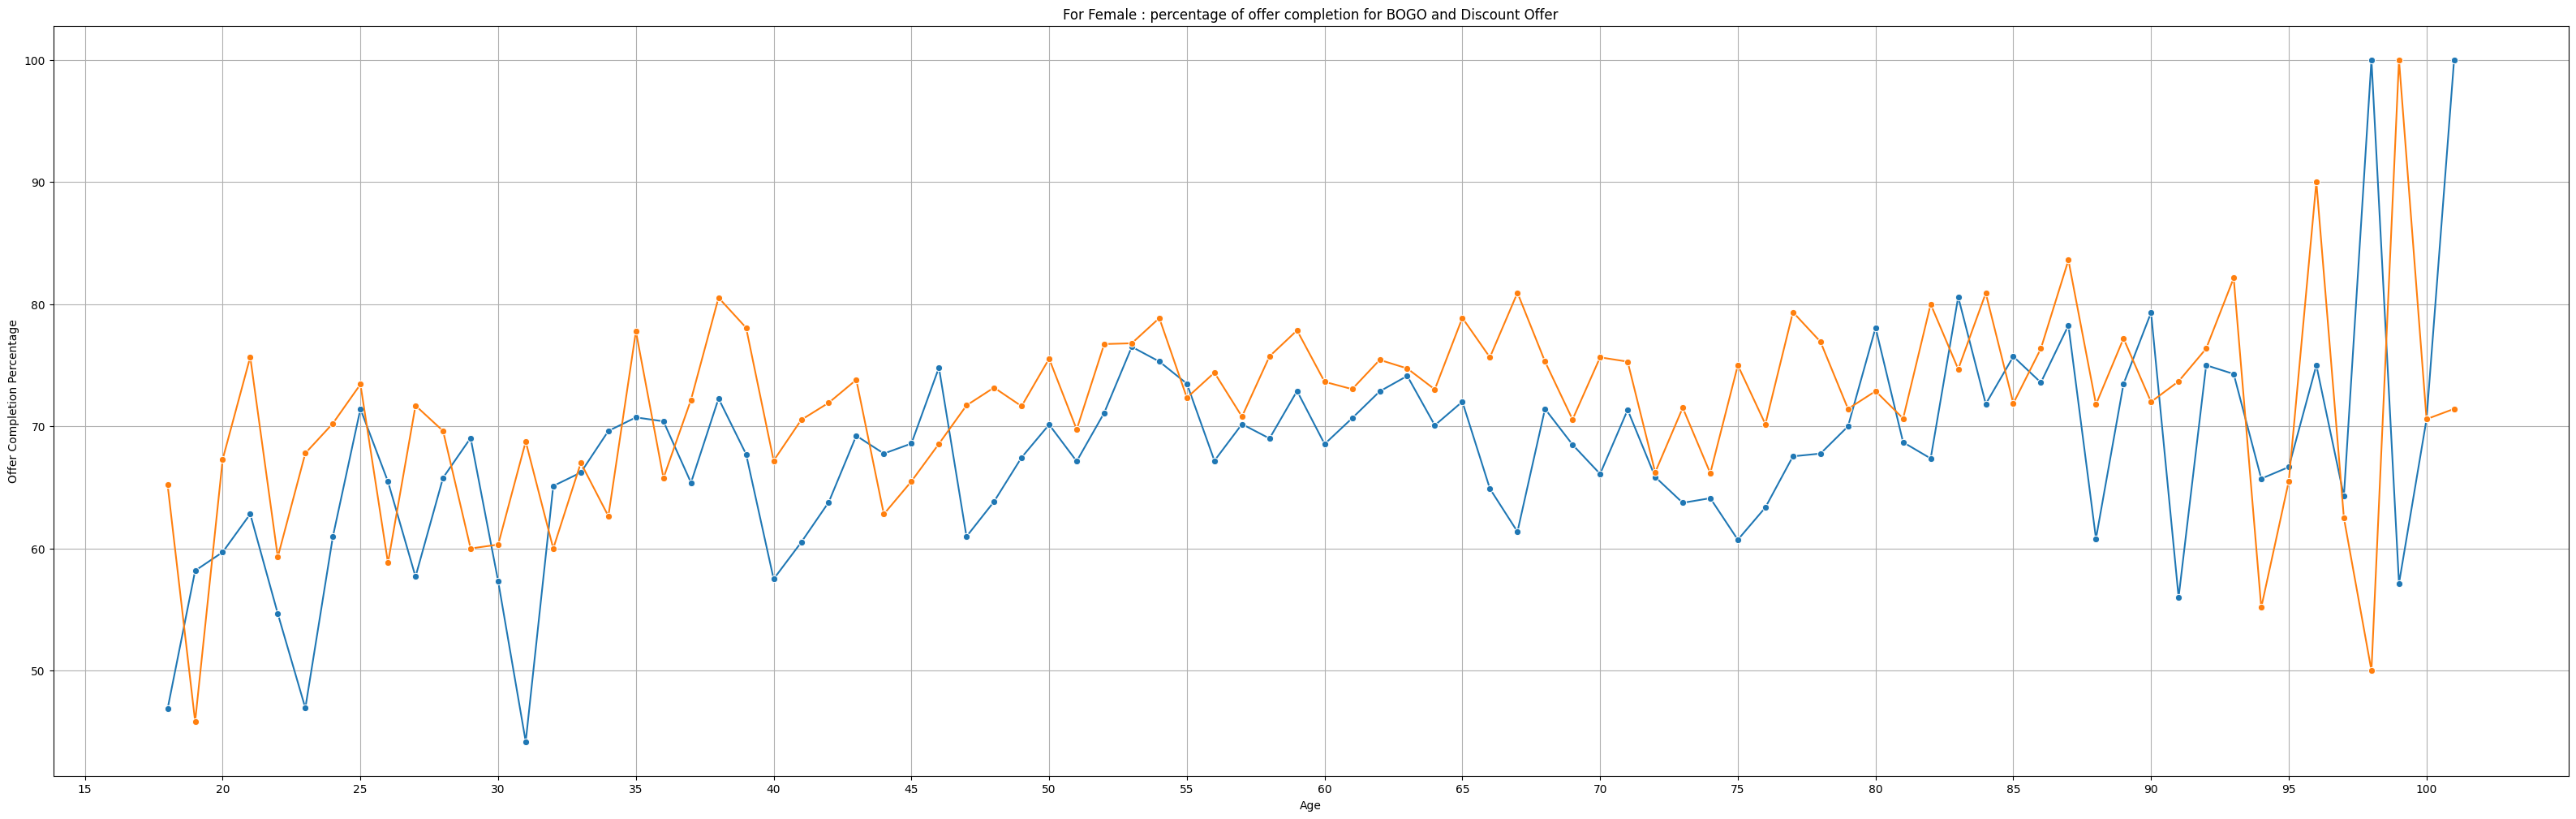

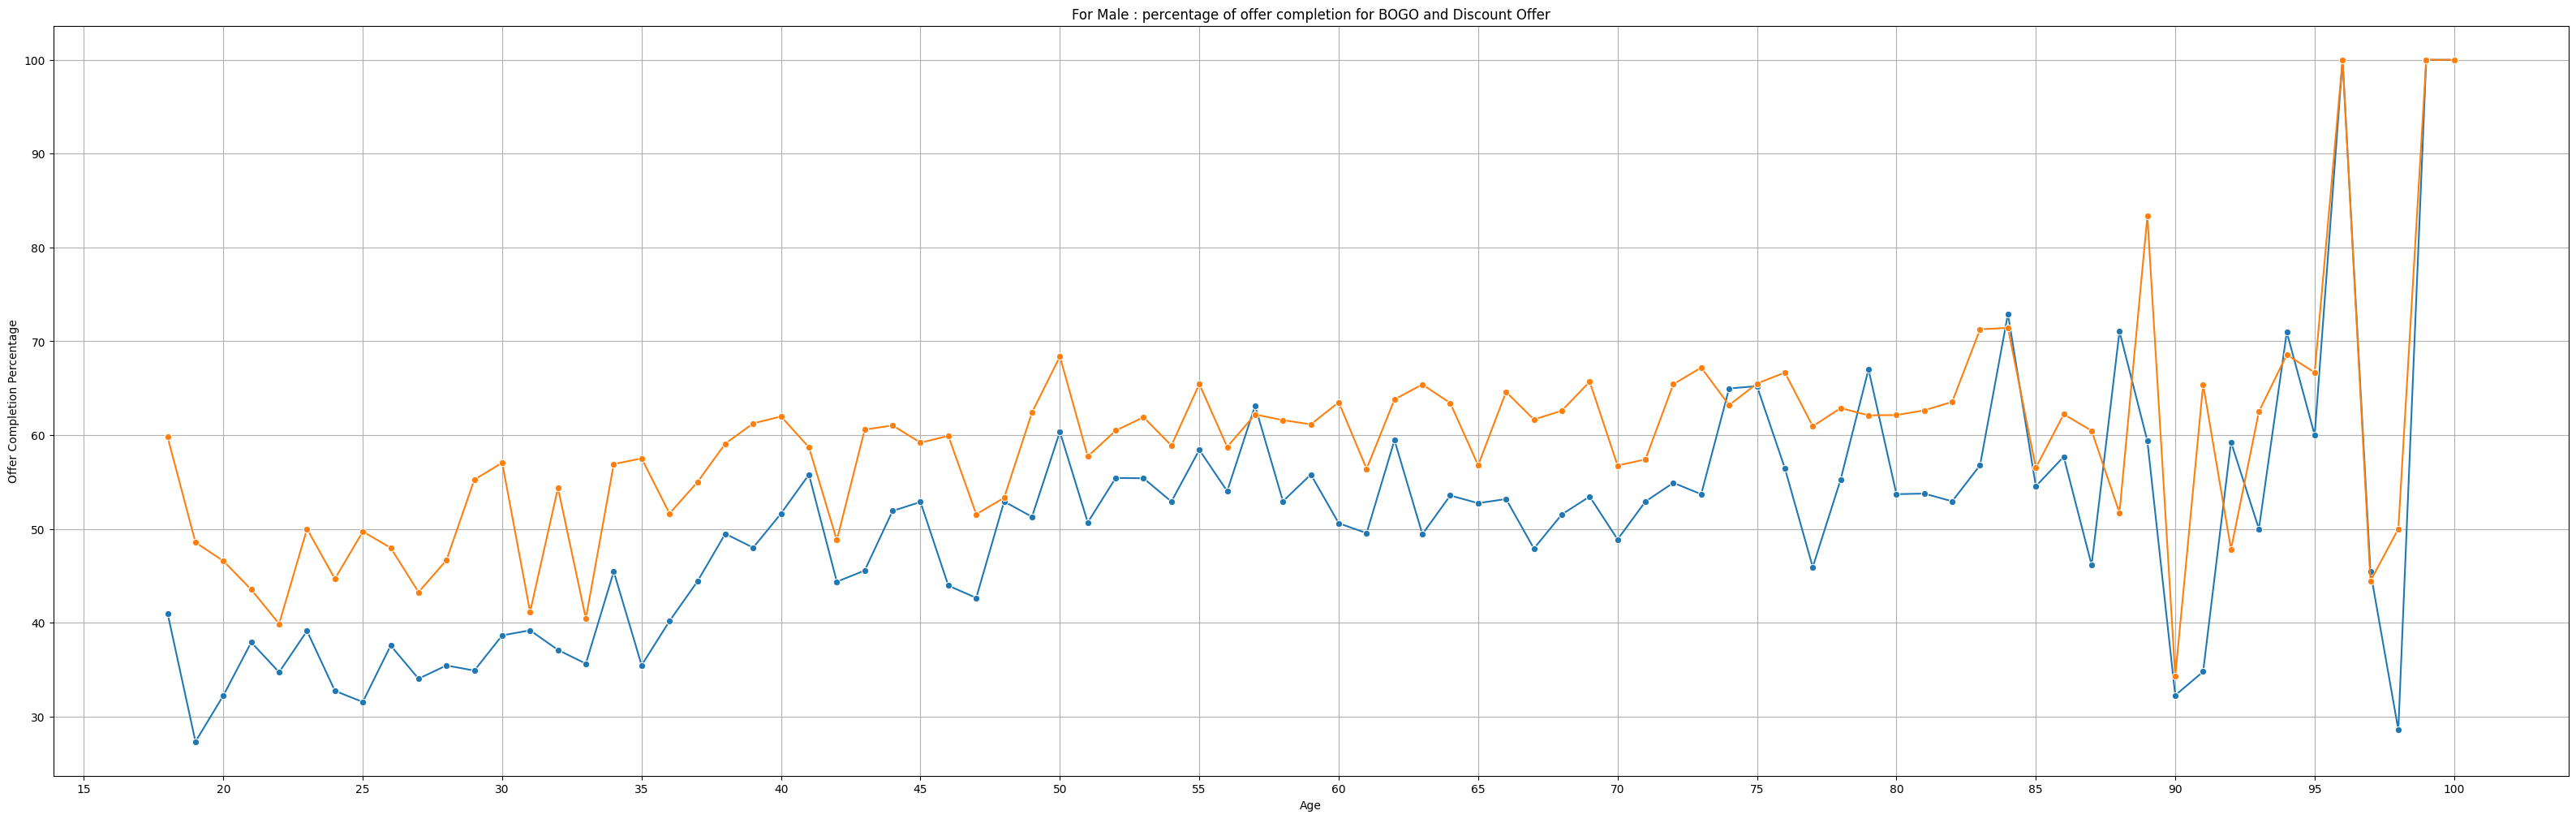

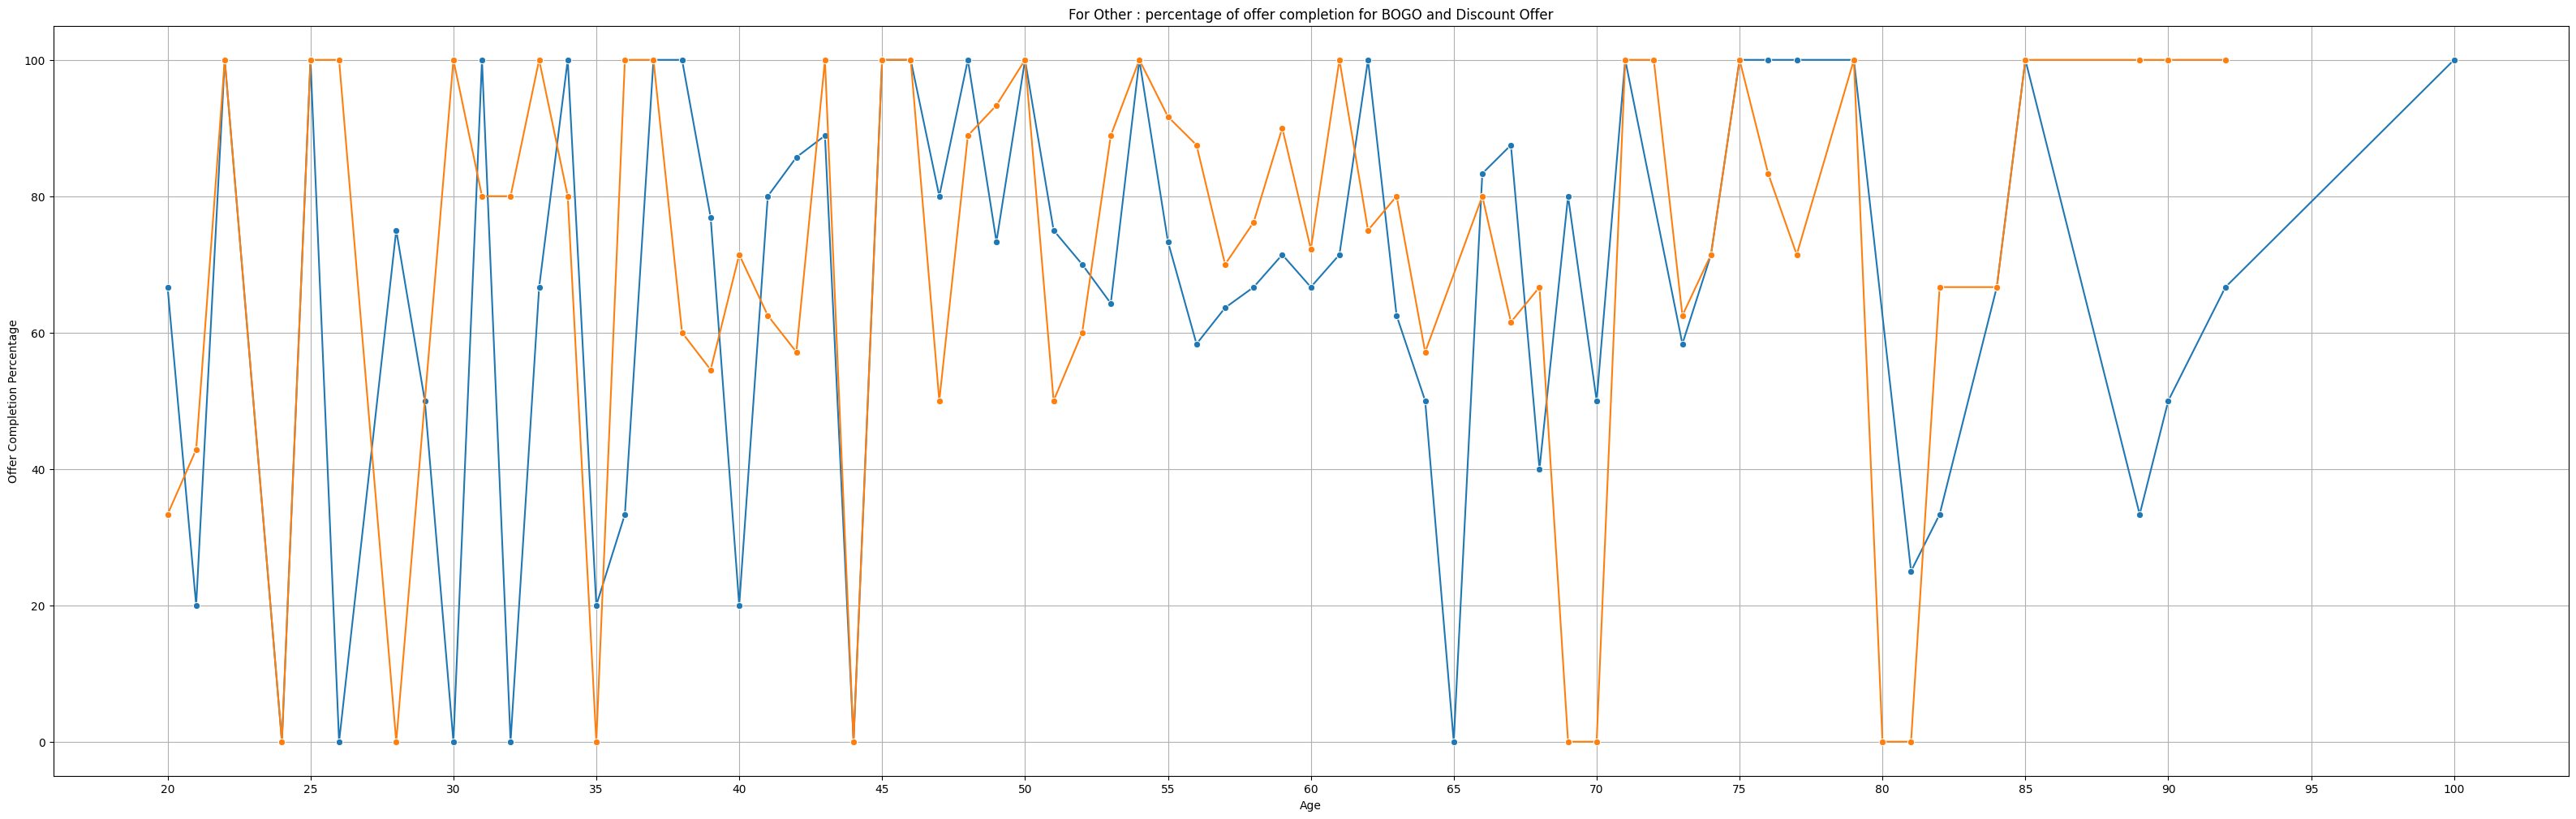

In [163]:
for g in ['F','M','O']:
    if (g == 'F'):
        gender_full = 'Female'
    elif (g == 'M'):
        gender_full = 'Male'
    elif (g == 'O'):
        gender_full = 'Other'

    print("------------------------------------------")
    print("Evaluating the {0} Demography".format(gender_full))
    print("------------------------------------------\n")
    df = getCompletedDf(sb3, g)
    print(df.head())
    plotCompletionChart(df, g, gender_full)



# end of notebook

## Code below is all commented, and reflect different R&D and attempts made in completing the capstone.
###### Feel free to review the code in cells below but it may fail


In [164]:
# sb3[sb3['gender']== 'F'].groupby(['age','offer_type'])['event_offer completed','event_offer received'].sum().unstack();
# # 

In [165]:
# x=sb3[sb3['gender']== 'F'].groupby(['age','offer_type'])['event_offer completed'].sum().unstack();
# y=sb3[sb3['gender']== 'F'].groupby(['age','offer_type'])['event_offer received'].sum().unstack();

# z=x/y*100
# # print(z)

In [166]:
# z=z.reset_index()


In [167]:
# z.head()

In [168]:
# for g in ['F','M','O']:
#     if (g == 'F'):
#         gender_full = 'Female'
#     elif (g == 'M'):
#         gender_full = 'Male'
#     elif (g == 'O'):
#         gender_full = 'Other'

#     print("------------------------------------------")
#     print("Evaluating the {0} Demography".format(gender_full))
#     print("------------------------------------------\n")
#     plotCompletionChart(sb3, g, gender_full)



In [169]:
# plt.figure(figsize=(40,12))
# ax = plt.subplot()
# # sns.barplot(x='age', y='offer_complete_percentage', hue='offer3',ci=None, data = sb3[sb3['gender'] == 'F'])
# # sns.barplot(x='age', y='amount', hue='offer_type',ci=None, data = sb3[sb3['gender'] == 'F'])

# plt.style.use('default')
# plt.grid(True, which='both')

# gender='F'
# age_step = 5
# age_min = (sb3[sb3['gender'] == gender].age.min() // age_step ) * age_step
# age_max = ((sb3[sb3['gender'] == gender].age.max() + age_step ) // age_step) * age_step

# sns.lineplot(x='age', y='amount', 
#              hue='offer_type' , style='offer3',  
#              legend='full',
#              ci=None, marker="o", data = sb3[sb3['gender'] == gender]
#             )
# ax.set_xticks(np.arange(age_min, age_max, 5))
# ax.set_xlabel('Age')
# ax.set_ylabel('Amount Spent')

# plt.title('For Female : Relationship between Age, Amount Spent and offer')

In [170]:
# plt.figure(figsize=(40,12))
# ax = plt.subplot()
# # sns.barplot(x='age', y='offer_complete_percentage', hue='offer3',ci=None, data = sb3[sb3['gender'] == 'F'])
# # sns.barplot(x='age', y='amount', hue='offer_type',ci=None, data = sb3[sb3['gender'] == 'F'])

# plt.style.use('default')
# plt.grid(True, which='both')

# gender='F'
# age_step = 5
# age_min = (sb3[sb3['gender'] == gender].age.min() // age_step ) * age_step
# age_max = ((sb3[sb3['gender'] == gender].age.max() + age_step ) // age_step) * age_step

# sns.lineplot(x='age', y='offer_complete_percentage', 
#              hue='offer_type' , style='offer3',  
#              legend='full',
#              estimator='sum',
#              ci=None, marker="o", data = sb3[sb3['gender'] == gender]
#             )
# ax.set_xticks(np.arange(age_min, age_max, 5))
# ax.set_xlabel('Age')
# ax.set_ylabel('Offer Completion Percentage')

# plt.title('For Female : Relationship between Age, Amount Spent and offer')

In [171]:
# plt.figure(figsize=(40,12))
# ax = plt.subplot()
# # sns.barplot(x='age', y='offer_complete_percentage', hue='offer3',ci=None, data = sb3[sb3['gender'] == 'F'])
# # sns.barplot(x='age', y='amount', hue='offer_type',ci=None, data = sb3[sb3['gender'] == 'F'])

# plt.style.use('default')
# plt.grid(True, which='both')

# gender='M'
# age_step = 5
# age_min = (sb3[sb3['gender'] == gender].age.min() // age_step ) * age_step
# age_max = ((sb3[sb3['gender'] == gender].age.max() + age_step ) // age_step) * age_step

# sns.lineplot(x='age', y='amount', 
#              hue='offer_type' , style='offer3',  
#              legend='full',
#              estimator='sum',
#              ci=None, marker="o", data = sb3[sb3['gender'] == gender]
#             )
# ax.set_xticks(np.arange(age_min, age_max, 5))
# ax.set_xlabel('Age')
# ax.set_ylabel('Amount Spent')

# plt.title('For Male : Relationship between Age, Amount Spent and offer')

In [172]:
# plt.figure(figsize=(40,12))
# ax = plt.subplot()
# # sns.barplot(x='age', y='offer_complete_percentage', hue='offer3',ci=None, data = sb3[sb3['gender'] == 'F'])
# # sns.barplot(x='age', y='amount', hue='offer_type',ci=None, data = sb3[sb3['gender'] == 'F'])

# plt.style.use('default')
# plt.grid(True, which='both')

# gender='F'
# age_step = 5
# age_min = (sb3[sb3['gender'] == gender].age.min() // age_step ) * age_step
# age_max = ((sb3[sb3['gender'] == gender].age.max() + age_step ) // age_step) * age_step

# sns.lineplot(x='age', y='offer_complete_percentage', 
#              hue='offer_type' , style='offer3',  
#              legend='full',
#              estimator='sum',
#              ci=None, marker="o", data = sb3[sb3['gender'] == gender]
#             )
# ax.set_xticks(np.arange(age_min, age_max, 5))
# ax.set_xlabel('Age')
# ax.set_ylabel('Offer Completion Percentage')

# plt.title('For Male : Relationship between Age, Amount Spent and offer')

In [173]:
# sb3.head()

In [174]:
# sb_female_group_offer  = sb3[sb3['gender']=='F'].groupby(['age','offer_type'])['amount'].sum().unstack()
# sb_female_group_person = sb3[sb3['gender']=='F'].groupby(['age','offer_type'])['person_count'].sum().unstack()

# sb_male_group_offer  = sb3[sb3['gender']=='M'].groupby(['age','offer_type'])['amount'].sum().unstack()
# sb_male_group_person = sb3[sb3['gender']=='M'].groupby(['age','offer_type'])['person_count'].sum().unstack()

# sb_other_group_offer  = sb3[sb3['gender']=='O'].groupby(['age','offer_type'])['amount'].sum().unstack()
# sb_other_group_person = sb3[sb3['gender']=='O'].groupby(['age','offer_type'])['person_count'].sum().unstack()



In [175]:
# sb_female_avg_spent_age = sb_female_group_offer / sb_female_group_person

In [176]:
# sb_female_avg_spent_age 

In [177]:
# # https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#the-where-method-and-masking


# conditions = [
#     (sb_female_avg_spent_age['bogo'] >  sb_female_avg_spent_age['discount']) ,
#     (sb_female_avg_spent_age['bogo'] <  sb_female_avg_spent_age['discount']) ]

# choices = ['send bogo offer', 'send discount offer']
# # , 'send either bogo or discount', 'dont send offer']

# sb_female_avg_spent_age['bogo_or_discount'] = np.select(conditions, choices, default='send either bogo or discount')



# conditions = [
#     (sb_female_avg_spent_age['None'] >  sb_female_avg_spent_age['informational']),
#     (sb_female_avg_spent_age['None'] <  sb_female_avg_spent_age['informational'])
# ]

# choices = ['dont send informational offer', 'send informational email']

# sb_female_avg_spent_age['info_or_none'] = np.select(conditions, choices, default='dont send informational offer')




In [178]:
# sb_female_avg_spent_age 

In [179]:
# female_bogo = sb_female_avg_spent_age[sb_female_avg_spent_age['bogo_or_discount'] == 'send bogo offer'].index.values
# female_discount = sb_female_avg_spent_age[sb_female_avg_spent_age['bogo_or_discount'] == 'send discount offer'].index.values
# female_bogo_discount = sb_female_avg_spent_age[sb_female_avg_spent_age['bogo_or_discount'] == 'send either bogo or discount'].index.values

# female_dont_send_info = sb_female_avg_spent_age[sb_female_avg_spent_age['info_or_none'] == 'dont send informational offer'].index.values
# female_send_info = sb_female_avg_spent_age[sb_female_avg_spent_age['info_or_none'] == 'send informational email'].index.values


# print('Females - send bogo offer to the {0} age group \n {1} \n '.format(len(female_bogo), female_bogo) )
# print('Females - send discount offer to the {0} age group \n {1} \n '.format(len(female_discount), female_discount) )
# print('Females - send any, bogo or discount offer to the {0} age group \n {1} \n '.format(len(female_bogo_discount), female_bogo_discount) )

# print('Females - don''t send informational offer to the {0} age group \n {1} \n '.format(len(female_dont_send_info), female_dont_send_info) )
# print('Females - send informational offer  to the {0} age group \n {1} \n '.format(len(female_send_info), female_send_info) )


In [180]:
# sbpivot.columns

In [181]:
# sbpivot.T

In [182]:
# sbpivot_person = sb3[sb3['gender']=='F'].pivot_table(columns=['age'], index=['offer3','offer_type'], aggfunc=np.sum)['person_count' ].reset_index()
# sbpivot_person
# # sb3[(sb3['gender']=='F') & (sb3['age'] == 18)]


In [183]:
# # sbpivot = sb3[sb3['gender']=='F'].pivot_table(index=['age'], columns=['offer3','offer_type'], aggfunc=np.sum)['person_count' ].reset_index()
# sbpivot_amt = sb3[sb3['gender']=='F'].pivot_table(columns=['age'], index=['offer3','offer_type'], aggfunc=np.sum)['amount' ].reset_index()
# sbpivot_amt


In [184]:
# sbpivot = sbpivot_amt.copy() 
# for i in sbpivot.columns:
#     if (isinstance(i, int) ):
#         for j in range(sbpivot.shape[0]):
#             print(sbpivot_amt[i][j], sbpivot_person[i][j])
#             sbpivot[i][j] = sbpivot_amt[i][j] / sbpivot_person[i][j]
# #             print(type(sbpivot[i][j]))

In [185]:
# temp_amt = sbpivot_amt.drop(columns=['offer3','offer_type']).copy()
# #                 trans2.drop(columns = ['value', 'offer_id','offer id'], inplace=True)

In [186]:
# temp_person = sbpivot_person.drop(columns=['offer3','offer_type']).copy()


In [187]:
# sbpivot_amt[['offer3','offer_type']]

In [188]:
# temp = temp_amt / temp_person

In [189]:
# sb4 = sbpivot_amt[['offer3','offer_type']].join(temp ) 

In [190]:
# sb4.T

In [191]:
# plt.figure(figsize=(40,12))
# ax = plt.subplot()
# # sns.barplot(x='age', y='offer_complete_percentage', hue='offer3',ci=None, data = sb3[sb3['gender'] == 'F'])
# # sns.barplot(x='age', y='amount', hue='offer_type',ci=None, data = sb3[sb3['gender'] == 'F'])

# plt.style.use('default')
# plt.grid(True, which='both')

# # sns.lineplot(x='age', y='amount', 
# #              hue='offer_type' , style='offer3',  
# #              legend='full',
# #              ci=None, marker="o", data = sb4
# #             )
# sns.lineplot( data = sb4
#             )
# ax.set_xticks(np.arange(age_min, age_max, 5))
# ax.set_xlabel('Age')
# ax.set_ylabel('Amount Spent')

# plt.title('For Female : Relationship between Age, Amount Spent and offer')

In [192]:
# type(sbpivot)

In [193]:
# sb4.columns

In [194]:
# sbpivot.T

In [195]:
# sbpivot.index

In [196]:
# sbpivot.index.get_level_values(0)

In [197]:
# sbpivot.index.get_level_values(1)

In [198]:
# ((sb3.age.max() + 5) // 5) * 5

In [199]:
# plt.figure(figsize=(35,8))

# # chartdata = sb3[(sb3['gender'] == 'F') & 
# #                 (sb3['offer_type'].isin(['None','informational']))]
# chartdata = sb3[(sb3['offer_type'].isin(['None','informational']))]

# sns.relplot(x='age', y='amount', hue='offer_type',  col='offer3',
#             kind='line', ci=None, 
#             data = chartdata
#            )

# plt.title('Relationship between Age, amount and percentage of amount spent')


In [200]:
# sb3.offer_type.unique()

In [201]:
# correlation = sb2[['income','age','amount','gender_M', 'gender_F', 'gender_O']].corr()
# # plt.figure(figsize=(20,20))
# sns.heatmap(correlation, linecolor='white',linewidths=0.1, annot=True)
# # plt.title('Correlation Matrix')
# # plt.xlabel('starbucks offers')
# # plt.ylabel('starbucks offers')
# plt.show()

In [202]:
# plt.figure(figsize=(20,8))
# sns.barplot(x='age_group', y='spent_percentage', hue='offerYesNo', data = sb3)

# plt.title('Relationship between Age, amount and percentage of amount spent')

In [203]:
# over_half_purchase_wo_offer = sb3[(sb3['offerYesNo'] != 'Offer') & (sb3['spent_percentage'] >= 50)]

In [204]:
# over_half_purchase_wo_offer.head()

In [205]:
# plt.figure(figsize=(20,8))
# sns.barplot(x='income', y='spent_percentage', hue='gender', data = over_half_purchase_wo_offer)

# plt.title('Relationship between Age, amount and percentage of amount spent')

In [206]:
# sb3.corr()

In [207]:
# correlation = sb3.corr()
# plt.figure(figsize=(20,20))
# sns.heatmap(correlation, linecolor='white',linewidths=0.1, annot=True)
# plt.title('Correlation Matrix')
# plt.xlabel('starbucks offers')
# plt.ylabel('starbucks offers')
# plt.show()

In [208]:
# plt.figure(figsize=(20,8))
# sns.set_theme(style="whitegrid")
# g = sns.catplot(
#     data=sb3, kind="bar",
#     x="age", y="amount", hue="offerYesNo",
#     ci="sd", palette="dark", alpha=.6, height=6
# )
# g.despine(left=True)
# g.set_axis_labels("", "Body mass (g)")
# g.legend.set_title("")

In [209]:
# import sys
# !{sys.executable} -m pip install seaborn==0.11.2

In [210]:
# import pkg_resources
# root_packages=['seaborn']
# for m in pkg_resources.working_set:
#     if m.project_name.lower() in root_packages:
#         print(f"{m.project_name}=={m.version}")

In [211]:
# import seaborn as sns
# sns.__version__

#### sb2  - dataframe with the person + offer summary
#### sb3 - dataframe with the person + offer/No-Offer

In [212]:
# sb3.shape

### Exploratory Data Analysis to answer the questions

In [213]:
# # d=newdf[newdf.isin(['offer received', 'offer viewed', 'offer completed'])]
# # d1 = newdf.reindex()
# # d = newdf.loc[pd.Index(['offer received', 'offer viewed', 'offer completed'])]

# plt.figure(figsize=(20,12))
# g=sns.countplot(x='age_group', hue='offerYesNo', data=sb3[sb3.age < 100])
# # plt.xticks(rotation=90)
# plt.show()

In [214]:
# # d=newdf[newdf.isin(['offer received', 'offer viewed', 'offer completed'])]
# # d1 = newdf.reindex()
# # d = newdf.loc[pd.Index(['offer received', 'offer viewed', 'offer completed'])]

# plt.figure(figsize=(20,12))
# g=sns.countplot(x='income_group', hue='gender', data=sb3)
# # plt.xticks(rotation=90)
# plt.show()

In [215]:
# sns.__version__

In [216]:
# sb3.groupby(by=['age', 'gender_M','gender_F','gender_O'])['person'].count().reset_index()

In [217]:

# labels = sb3.age.unique()
# men_means = [20, 34, 30, 35, 27]
# women_means = [25, 32, 34, 20, 25]

# x = np.arange(len(labels))  # the label locations
# width = 0.35  # the width of the bars

# fig, ax = plt.subplots()
# rects1 = ax.bar(x - width/2, men_means, width, label='Men')
# rects2 = ax.bar(x + width/2, women_means, width, label='Women')

# # Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel('Scores')
# ax.set_title('Scores by group and gender')
# ax.set_xticks(x)
# ax.set_xticklabels(labels)
# ax.legend()

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)

# fig.tight_layout()

# plt.show()

In [218]:

# labels = ['G1', 'G2', 'G3', 'G4', 'G5']
# men_means = [20, 34, 30, 35, 27]
# women_means = [25, 32, 34, 20, 25]

# x = np.arange(len(labels))  # the label locations
# width = 0.35  # the width of the bars

# fig, ax = plt.subplots()
# rects1 = ax.bar(x - width/2, men_means, width, label='Men')
# rects2 = ax.bar(x + width/2, women_means, width, label='Women')

# # Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel('Scores')
# ax.set_title('Scores by group and gender')
# ax.set_xticks(x)
# ax.set_xticklabels(labels)
# ax.legend()

# # ax.bar_label(rects1, padding=3)
# # ax.bar_label(rects2, padding=3)

# fig.tight_layout()

# plt.show()

In [219]:
# newdf.corr()

In [220]:
# correlation = newdf.corr()
# plt.figure(figsize=(20,20))
# sns.heatmap(correlation, linecolor='white',linewidths=0.1, annot=True)
# plt.title('Correlation Matrix')
# plt.xlabel('starbucks offers')
# plt.ylabel('starbucks offers')
# plt.show()

In [221]:
# newdf[newdf.person == '00116118485d4dfda04fdbaba9a87b5c'].groupby(by=['person','offer','event_offer received','event_offer viewed','event_offer completed']).sum()


In [222]:
# newdf[newdf.person == '00116118485d4dfda04fdbaba9a87b5c']

In [223]:
# newdf.columns

In [224]:
# newdf[(newdf['event_offer viewed'] == 1) & (newdf['event_offer received'] == 0)]

In [225]:
# transcript[(transcript['person'] == '78afa995795e4d85b5d9ceeca43f5fef')   ]

In [226]:

# pd.set_option('display.max_colwidth', 0)
# pd.set_option('display.max_columns', 0)

In [227]:
# newdf.reward.unique()

In [228]:
# print(714/24)

In [229]:
# newdf[(newdf.offer == 'f19421c1d4aa40978ebb69ca19b0e20d') & (newdf['event_offer received'] == 1)].groupby(['time'])['person'].count().reset_index()

In [230]:
# newdf[(newdf['event_offer received'] != 1)].groupby(['person']).count().reset_index()


#### Person who never received offer

In [231]:
# ofr_rcvd = newdf[newdf['event_offer received'] == 1]
# ofr_rcvd
# # newdf[(newdf['event_offer received'] == 1)].groupby(['time','offer' ])['person'].count().reset_index()

In [232]:
# a= set(profile['id'].values)
# b= set(ofr_rcvd['person'].values)
# z=a.difference(b)
# print(z)

In [233]:
# len(ofr_rcvd['person'].unique())

In [234]:

# sns.__version__

In [235]:
# x = newdf.groupby('time')['reward'].sum().reset_index()

In [236]:
# x

In [237]:
# plt.figure(figsize=(20,20))
# plt.bar(x.time, x.reward)
# plt.show()

In [238]:
# plt.figure(figsize=(20,10))
# sns.barplot(x='time', y='reward', data=x)
# plt.show()

In [239]:
# newdf[newdf['event2'] != 'transaction']

In [240]:
# # d=newdf[newdf.isin(['offer received', 'offer viewed', 'offer completed'])]
# # d1 = newdf.reindex()
# # d = newdf.loc[pd.Index(['offer received', 'offer viewed', 'offer completed'])]

# plt.figure(figsize=(20,12))
# g=sns.countplot(x='offer', hue='event2', data=newdf[newdf['event2'] != 'transaction'])
# plt.xticks(rotation=90)
# plt.show()

In [241]:
# plt.figure(figsize=(20,12))
# g=sns.countplot(x='offer_type2', hue='event2', data=newdf[newdf['event2'] != 'transaction'],  palette="Set2")
# plt.xticks(rotation=90)
# plt.show()

In [242]:
# newdf[newdf.event2 == 'offer completed']

In [243]:
# newdf[newdf.person == '12ede229379747bd8d74ccdc20097ca3']

In [244]:
# transcript.iloc[239474]

In [245]:
# transcript.iloc[239475]

## Create a summarized view of customer, offer and transaction data. such that each row will have a customer, offer, sum of transactions during validity period, offer completed or not


In [246]:
# len(newdf.person.unique())

In [247]:
# profile.shape[0]

In [248]:
# # def getPersonTrans(id):
# #     """
# #     return all the data from newdf for the person
    
# #     Input : id - person id 
    
# #     output: df - dataframe of all the transactions of the customer

# #     """
# #     return newdf[newdf['person'] == id]

# # from tqdm.notebook import tqdm
# # pbar = tqdm()
# # pbar.reset(total=len(profile.shape[0]))

# columnslist = ['person','offer','offer_received_time','offer_expiry_time','offer_duration_hrs',
#                 'count_received', 'count_completed', 'count_viewed', 'count_transactions','sum_trans','sum_reward']
# itemlist =[]

# counter =0
# persons = profile['id'].values
# for person in persons:  #profile['id']:
# #     pbar.update()
# #     trans = getPersonTrans(person)
# #     print('person = ', person)
    
#     # all transactions of the person
# #     person = 'fe97aa22dd3e48c8b143116a8403dd52'
#     person_trans = newdf[newdf['person'] == person]

#     # all offer received by the person
#     offer_received = person_trans[person_trans['event_offer received'] == 1]

#     counter=counter+1
    
#     if (counter % 100 == 0):
#         print (counter)
    
#     for idx,row in offer_received.iterrows():
        
#         person_id = row['person']
#         offer_id = row['offer']
#         offer_duration_hrs = row['duration'] * 24   # offer duration in hours
#         offer_received_time = row['time']
#         offer_expiry_time = offer_received_time + offer_duration_hrs

#         offer_period_activity = person_trans[(person_trans['time'] >= offer_received_time) &
#                                              (person_trans['time'] <= offer_expiry_time ) &
#                                              ( (person_trans['offer'] == offer_id) | 
#                                                (person_trans['offer'] == "")   
#                                              )
#                                             ]        

#         count_received     = offer_period_activity[offer_period_activity['event2'] == 'offer received']['person'].count()
#         count_completed    = offer_period_activity[offer_period_activity['event2'] == 'offer completed']['person'].count()
#         count_viewed       = offer_period_activity[offer_period_activity['event2'] == 'offer viewed']['person'].count()
#         count_transactions = offer_period_activity[offer_period_activity['event2'] == 'transaction']['person'].count()
#         sum_trans          = offer_period_activity[offer_period_activity['event2'] == 'transaction']['amount'].sum()
#         sum_reward         = offer_period_activity[offer_period_activity['event2'] == 'offer_completed']['reward'].sum()

#         item = []
#         item.append(person_id)
#         item.append(offer_id)
#         item.append(offer_received_time)
#         item.append(offer_expiry_time)
#         item.append(offer_duration_hrs)
        
#         item.append(count_received)
#         item.append(count_completed)
#         item.append(count_viewed)
#         item.append(count_transactions)
#         item.append(sum_trans)
#         item.append(sum_reward)
        
# #         print('item = ', item)
#         itemlist.append(item)
# #     break;

# # print(itemlist)        

# # pbar.refresh()
# df2 = pd.DataFrame(itemlist, columns=columnslist)
# print(df2)
# #     print(or_count, oc_count, ov_count, ot_count)
# #         if row['event_offer received'] 
    
# #         print(row['person'])
# #         break;
# #     break;
    
    

In [249]:
# offer_period_activity[['reward','amount']].sum()

In [250]:
# person

In [251]:
# person_trans = newdf[newdf['person'] == 'fe97aa22dd3e48c8b143116a8403dd52']
# person_trans
# offer_received = person_trans[person_trans['event_offer received'] == 1]
# offer_received

In [252]:
# person_trans

In [253]:
# row = offer_received.iloc[0]
# row['offer']

In [254]:
# row = offer_received.iloc[0]

# offer_id = row['offer']
# offer_duration_hrs = row['duration'] * 24   # offer duration in hours
# offer_received_time = row['time']
# offer_expiry_time = offer_received_time + offer_duration_hrs
        
# offer_period_activity = person_trans[(person_trans['time'] >= offer_received_time) &
#                                              (person_trans['time'] <= offer_expiry_time ) &
#                                              ( (person_trans['offer'] == offer_id) | 
#                                                (person_trans['offer'] == "")   
#                                              )
#                                             ]

# or_count = offer_period_activity[offer_period_activity['event2'] == 'offer received']['person'].count()
# oc_count = offer_period_activity[offer_period_activity['event2'] == 'offer completed']['person'].count()
# ov_count = offer_period_activity[offer_period_activity['event2'] == 'offer viewed']['person'].count()
# ot_count=  offer_period_activity[offer_period_activity['event2'] == 'transaction']['person'].count()
# sum_trans          = offer_period_activity[offer_period_activity['event2'] == 'transaction']['amount'].sum()
# sum_reward         = offer_period_activity[offer_period_activity['event2'] == 'offer completed']['reward'].sum()


# lstlst =[]
# lst = []
# # lst.append([or_count, oc_count, ov_count, ot_count])
# lst.append(offer_received_time)
# lst.append(offer_expiry_time)
# lst.append(or_count)
# lst.append(oc_count)
# lst.append(ov_count)
# lst.append(ot_count)
# lst.append(sum_trans)
# lst.append(sum_reward)

# lstlst.append(lst)

# print(lstlst)

# print(offer_received_time, offer_expiry_time, or_count, oc_count, ov_count, ot_count, sum_trans, sum_reward)


# df2 = pd.DataFrame(lstlst,
#                    columns=['a', 'b', 'c','d','e','f','g','h'])
# print(df2)

In [255]:
# print(offer_received_time, offer_duration_hrs, offer_expiry_time )

In [256]:
# offer_period_activity

In [257]:
# or_count = offer_period_activity[offer_period_activity['event2'] == 'offer received']['person'].count()
# oc_count = offer_period_activity[offer_period_activity['event2'] == 'offer completed']['person'].count()
# ov_count = offer_period_activity[offer_period_activity['event2'] == 'offer viewed']['person'].count()
# ot_count=  offer_period_activity[offer_period_activity['event2'] == 'transaction']['person'].count()
# sum_trans = offer_period_activity[offer_period_activity['event2'] == 'transaction']['amount'].sum()
# sum_reward = offer_period_activity[offer_period_activity['event2'] == 'transaction']['reward'].sum()

# print(or_count, oc_count, ov_count, ot_count, sum_trans, sum_reward)